# はじめに

これは、古典制御理論と現代制御理論の関係を調べた計算ノートのようなものです。
古典制御理論(伝達関数表示）で記述された制御対称を現代制御理論（状態空間表示）で表現してみて、
それぞれの制御方式で制御した際の振る舞いを比較してみました。

現代制御理論の状態フィードバックのパラメータは古典制御理論のPID制御のようなわかりやすさにかけるのも、現代制御理論が受け入れられない
原因の一つかもしれません、状態フィードバックのパラメータの取り扱いについて、一つの提案をしています。この方法は取り扱いやすく、
かつ安定なフィードバックを実現できるので、使いやすいのではと思っています。ご意見をお聞かせいただければ、嬉しく思います。

このノートはまた、Python/controlモジュールの使い方の一例を示すものにもなっていると思います。ここで取り上げているのは、古典/現代　制御理論
の入門で取り上げられるような機能しか使っておりません。python/controlでは非線形のシステムの解析などにも役立つ関数が用意されているようです。
python/controlへのお誘いとして、役に立てばいいのですが。

最初はPythonプログラムは無視して、グラフなどを眺めるだけでもいいかと思います。興味がわいたところで、いろいろパラメータを換えてみるなど
試してみると面白いでしょう。

では、始めましょう。

# 伝達関数から状態空間表示へ

時間によって変化しない線形なシステム(Liner Time Independent System:LTI) の制御については
伝達関数表示を用いる古典制御理論と
状態変数表示を使う現代制御理論の
二つがよく知られています。単一入力単一出力(SISO)のシステムでは、これら二つの表示を行き来することは
簡単です。このメモでは、一つの制御対象を例題に二つの制御理論の関係をみていきたいと思います。 
状態空間表示では、入力と出力のいずれか、あるいは両方が複数あるシステム(MIMO)も同様に取り扱えるという優位性があります。


## 制御対象システム
このメモで取り上げる制御対象となるシステムとして、「Python による制御工学入門」第5章の垂直駆動アームをの例題を使います。
この系は、振り子を振り上げるモータの制御入力に対して、振り子の角度が制御出力となるSISOシステムです。

制御対象の運動方程式は、
$$
J\ddot{\theta}= -\mu \dot{\theta} - M g l \sin{\theta} + \tau(t)
$$
となります。$\tau(t)$ はモータのトルクとします。

このままでは、出力 $\theta$に対して、非線形となっていますので、LTIシステムとして取り扱うことができません。微小な $\theta$ に制限することで、システムを線形化します。

$$
J\ddot{\theta}= -\mu \dot{\theta} - M g l \theta + \tau(t)
$$

この方程式を、行列表記をつかって、

$$
\frac{d}{dt} \begin{bmatrix}\theta \\ \dot{\theta}\end{bmatrix} =  \begin{bmatrix} 0, & 1 \\  -\frac{M g l}{J},& -\frac{\mu}{J}\\ \end{bmatrix} \begin{bmatrix}\theta \\ \dot{\theta} \end{bmatrix} +\begin{bmatrix}0 \\ \tau(t)\end{bmatrix}
$$

と書き直せることに注意しましょう。

運動方程式をラプラス変換し、整理することで、制御対象は、次の伝達関数で表現されることがわかります。

$$
 \theta(s)= \frac{1}{ J s^2 + \mu s + M g l} \tau(s)
$$

ここで、Python による制御工学入門」に従って、制御の無駄時間(遅れ）を導入します。制御では、出力値$y$ (ここでは$\theta$)の測定を行い、入力値$u$ (ここでは$\tau$)を決定し、
システムの入力としますが、このプロセスに生じる時間の遅れを制御の無駄時間と呼んでいます。
後で見るように、無駄時間(delay)の導入によって、フィードバックシステムの発振が起こります。



In [1]:
import control, numpy, matplotlib
print(f"{numpy.__version__=},{control.__version__=},{matplotlib.__version__=}")
# import sympy, sympy.physics.control,sympy.abc
from numpy import diag,matrix,eye,diag, matmul
from numpy.linalg import eig, matrix_rank
from control import tf2ss, ss2tf,tf,ss,impulse_response, step_response, initial_response
from control.matlab import linspace, logspace
import  matplotlib.pyplot as pyplot
# グラフの既定の設定を変更する。
control.reset_defaults()
# control.use_fbs_defaults()
# control.use_matlab_defaults()
# control.use_numpy_matrix(flag=True, warn=True)
# control.use_legacy_defaults("0.8.4")

numpy.__version__='1.24.2',control.__version__='0.9.3.post2',matplotlib.__version__='3.7.1'


In [2]:
# ## モデルの設定
# model:「Python による制御工学入門」　リスト 5.1 144ページ
g=9.81
l=0.2
M=0.5
Mgl=M*g*l
mu=1.5e-2
J=1.0e-2
ref=30 

# 測定の時間送れをパデ近似を使って設定します。
delay=0.005
num_delay,den_delay=control.pade(delay,1) #ここでパデ近似の次数を指定します。
delay_tf=tf(num_delay,den_delay)
print("無駄時間の伝達関数:\n",delay_tf.minreal())
#
Plant0=tf([ 1],[J, mu, Mgl],name="制御モデル 時間遅れ無",inputs="r",outputs="y").minreal()
# add delay with pade approximation
Plant=(delay_tf*Plant0).minreal()
Plant.name="制御モデル 時間遅れ有"
print("最小実現(時間遅れ無):",Plant0)
print("最小実現(時間遅れ有):",Plant)
print("二つのシステムの零点と極の位置を求めてみましょう。")
print("極(時間遅れ無)：",Plant0.poles(),"零点:(時間遅れ無)",Plant0.zeros())
print("極(時間遅れ有)：", Plant.poles(),"零点(時間遅れ有):",Plant.zeros())
print("DCgain:(時間遅れ無)",Plant0.dcgain(),"(時間遅れ有)",Plant.dcgain())

無駄時間の伝達関数:
 
-s + 400
--------
s + 400

最小実現(時間遅れ無): 
       100
------------------
s^2 + 1.5 s + 98.1

最小実現(時間遅れ有): 
           -100 s + 4e+04
-------------------------------------
s^3 + 401.5 s^2 + 698.1 s + 3.924e+04

二つのシステムの零点と極の位置を求めてみましょう。
極(時間遅れ無)： [-0.75+9.87610753j -0.75-9.87610753j] 零点:(時間遅れ無) []
極(時間遅れ有)： [-400.  +0.j           -0.75+9.87610753j   -0.75-9.87610753j] 零点(時間遅れ有): [400.+0.j]
DCgain:(時間遅れ無) 1.0193679918450558 (時間遅れ有) 1.019367991845054


### モデルの時間応答グラフ
モデルの制御無の状態での時間応答のグラフを作成します。controlには、forced_response, impulse_response, initial_response,step_response,
input_output_responseといったシステムの時間応答を求める関数が用意されています。ここでは、ステップ応答とインパルス応答を時間遅れ有／無の二つで
比較してみます。 生成した時間応答データのグラフ化には、matplotlibを使います。


<Figure size 432x288 with 0 Axes>

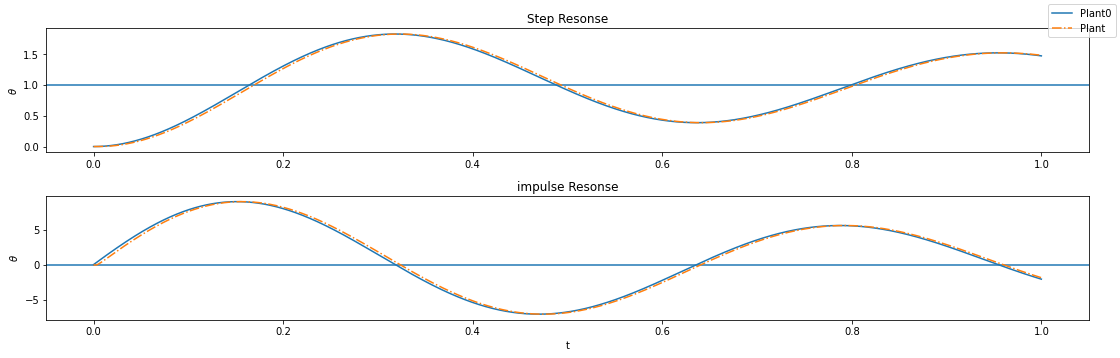

In [3]:
pyplot.clf()
fig,axes=pyplot.subplots(2,1)
fig.set_size_inches(10,5)
axes[0].set_title("Step Resonse");axes[1].set_title("impulse Resonse");
axes[1].set_xlabel("t");
axes[0].set_ylabel(r"$\theta$");axes[1].set_ylabel(r"$\theta$");

axes[0].axhline(1);axes[1].axhline(0);
fig.tight_layout();fig.set_size_inches((16,5))

T=linspace(0,1,4096)

#無駄時間なしシステムの時間応答
sres=step_response(Plant0,T)
ires=impulse_response(Plant0,T)
axes[0].plot(sres.t, sres.y[0,0,:], ls="-",label="Plant0")
axes[1].plot(ires.t, ires.y[0,0,:], ls="-")

#無駄時間なありシステムの時間応答
sres=step_response(Plant,T)
ires=impulse_response(Plant,T)
axes[0].plot(sres.t, sres.y[0,0,:],ls="-.", label="Plant")
axes[1].plot(ires.t, ires.y[0,0,:],ls="-.")

fig.legend();

## P制御付きシステムの時間応答
モデルにP制御のフィードバックを追加してみます。時間遅れが存在することによって、大きなフィードバック係数の場合にはシステムが不安定になることを確認しましょう。


### control.feedback

python/control module にはフィードバックループを作成するための関数　`control.feedback` 関数が用意されています。
関数のプロトタイプは、
```
contro.feedback(SYS1, SYS2=1, sign=-1)
```
で、フィードバックループを表現する伝達関数あるいは、状態変数表示を値として返します。
作成された State オブジェクトは プライマリの　State：SYS1と同じ、入力と出力を持ちます。
次のセルのGraphvizで作成した図を参考にしてください。

また、伝達関数(`tf`)や状態変数表示(`ss`)のオブジェクトにも、feedbackメソッドが存在します。`control.feedback(SYS1, SYS2, sign)`と
`SYS1.feedback(SYS2,sign)` は等価です。

これらの関数／メソッドによるダイアグラムを graphviz を使って作成します。

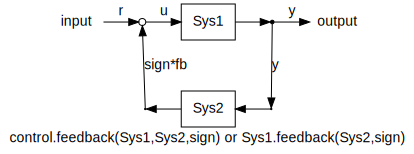

In [4]:
"""
## control.feedback(Sys1,Sys2,sign)
"""
#pip install -U graphviz
import graphviz
g=graphviz.Digraph("G", graph_attr={"rankdir":"TB","rank":"same"},engine="dot") # or circo
g.attr(fontname="Helvetica,Arial,sans-serif")
g.attr(label="control.feedback(Sys1,Sys2,sign) or Sys1.feedback(Sys2,sign)")
#g.attr(orientation="L")

g.attr("node",fontname="Helvetica,Arial,sans-serif")
g.attr("edge",fontname="Helvetica,Arial,sans-serif")

g.node("input", shape="plaintext")
g.node("mixer", label="", shape="ellipse", height="0.1", width="0.1",)
g.node("output", shape="plaintext")
g.node("splitter", label="", shape="point", height="0.05", width="0.05")
g.node("corner1", label="", shape="point", height="0.02", width="0.02")
g.node("corner2", label="", shape="point", height="0.02", width="0.02")

g.node("Sys1",shape="box")
g.node("Sys2",shape="box")

with g.subgraph(name="upper") as sg:
  sg.graph_attr['rankdir']='LR'
  sg.graph_attr['rank']='same'
  sg.edge("input","mixer", label="r")
  sg.edge("mixer","Sys1", label="u")
  sg.edge("Sys1","splitter")
  sg.edge("splitter","output",label="y")
  
g.edge("splitter","corner2",label="y")
g.edge("corner1","mixer",label="sign*fb")

with g.subgraph(name="lower") as sg:
  sg.attr("graph",rankdir="LR",rank="same")
  sg.edge("Sys2","corner2",dir="back")
  sg.edge("corner1","Sys2",dir="back")
g

### P制御
時間遅れ有のモデル(`Plant`)に異なるゲイン($K$)のP制御を追加したシステム $\frac{ P K}{1 + P K}$の時間応答を調べてみます。
このフィードバックされたシステムは、`control.feedback(P*K, 1, -1)`あるいは `(P*K).feedback()`と書くことができます。

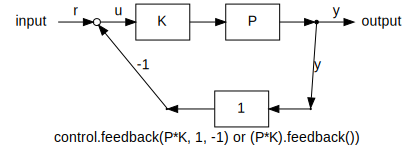

In [5]:
"""
## control.feedback(Plant*K, 1, -1) or (Plant*K).feedback()
"""
#pip install -U graphviz
import graphviz
g=graphviz.Digraph("G", graph_attr={"rankdir":"TB","rank":"same"},engine="dot") 
g.attr(fontname="Helvetica,Arial,sans-serif")
g.attr(label="control.feedback(P*K, 1, -1) or (P*K).feedback())")
#g.attr(orientation="L")

g.attr("node",fontname="Helvetica,Arial,sans-serif")
g.attr("edge",fontname="Helvetica,Arial,sans-serif")

g.node("input", shape="plaintext")
g.node("mixer", label="", shape="ellipse", height="0.1", width="0.1",)
g.node("output", shape="plaintext")
g.node("corner1", label="", shape="point", height="0.02", width="0.02")
g.node("splitter", label="", shape="point", height="0.05", width="0.05")
g.node("corner2", label="", shape="point", height="0.02", width="0.02")

g.node("K",shape="box")
g.node("P",shape="box")
g.node("U",shape="box", label="1")

with g.subgraph(name="upper") as sg:
  sg.graph_attr['rankdir']='LR'
  sg.graph_attr['rank']='same'
  sg.edge("input","mixer", label="r")
  sg.edge("mixer","K", label="u")
  sg.edge("K","P")
  sg.edge("P","splitter")
  sg.edge("splitter","output",label="y")
  
with g.subgraph(name="lower") as sg:
  sg.attr("graph",rankdir="LR",rank="same")
  sg.edge("corner1","U",dir="back")
  sg.edge("U","corner2",dir="back")

g.edge("corner1","mixer",label="-1")
g.edge("splitter","corner2",label="y")

g

python/controlモジュールには、linear time-invariant (LTI) systemsでの時間応答を調べるための、forced_response/impulse_response/initial_response　が用意されています。
ここでは、step_responseを使って、
`kp=3`の場合には、振動がほぼ一定値で続いていることがわかります。  

dcgain for kp=1 	0.5047955577990908, 	margins=(2.007450405489689, 4.992367243147129, 19.933764307100347, 17.211487404059895)
dcgain for kp=1.76 	0.6421014228383797, 	margins=(0.7087786394827778, -1.766112743375487, 19.933764307100347, 21.180681929127346)
dcgain for kp=3 	0.7535795026375278, 	margins=(0.0024834684965639687, -7.511516128136776, 19.933764307100354, 26.372392813967032)
dcgain for kp=3.008 	0.7540737026823761, 	margins=(inf, -7.540099312816778, nan, 26.40246774471753)


<Figure size 432x288 with 0 Axes>

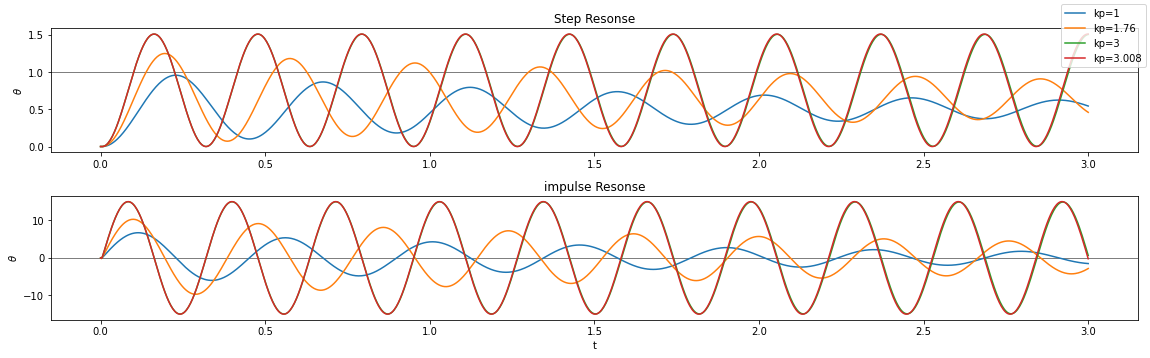

In [6]:
pyplot.clf()
fig,axes=pyplot.subplots(2,1)
fig.set_size_inches(16,5)
axes[0].axhline(1, color="k", linewidth=0.5)
axes[1].axhline(0, color="k", linewidth=0.5)
axes[0].set_title("Step Resonse");axes[1].set_title("impulse Resonse");
axes[1].set_xlabel("t");
axes[0].set_ylabel(r"$\theta$");axes[1].set_ylabel(r"$\theta$");

T=linspace(0,3,1000)
kps=(1, 1.76, 3,3.008)

for kp in (kps):
  K=tf([kp],[1])  # feedback gain kp
  fbsys=(Plant*K).feedback(1)  #signの既定値はsign=-1です。　(Plant*K).feedback(1)　== (Plant*K).feedback(1,-1) ==(Plant*K).feedback()
  #fbsys=control.feedback(Plant*K,　1,　-1) # 上記と等価
  sres=step_response(fbsys,T)
  ires=impulse_response(fbsys,T)
  axes[0].plot(sres.t, sres.y[0,0,:], label=f"kp={kp}")
  axes[1].plot(ires.t, ires.y[0,0,:])
  print(f"dcgain for kp={kp} \t{fbsys.dcgain()}, \tmargins={control.margin(fbsys)}")
fig.tight_layout(); fig.legend();

## P制御されたモデルの周波数応答を表示します。
P制御されたモデルの周波数応答をみるために、bode図を作成してみましょう。controlモジュールの`bode()`関数はSIOの伝達関数あるいは状態変数表示
を引数に取ります。MIMO(複数入力複数出力）のLTIシステムの場合には、frequency_response()関数あるいはメソッドを使います。

margin        : (gm:gain margin, pm:phase margin, pc:phase cross over, gc:gain cossover)
margin(plant) : (3.0074504054896884, 8.11056518752136, 19.933764307100347, 13.995414100411594)


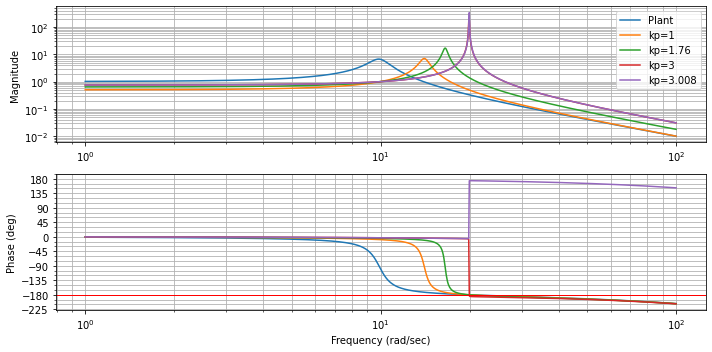

In [7]:
#omega=linspace(0.1,1e3,1024)
omega=logspace(1,1e2,1024)
print("margin        : (gm:gain margin, pm:phase margin, pc:phase cross over, gc:gain cossover)")
print("margin(plant) :", control.margin(Plant))

bp=control.bode_plot(Plant,omega_limits=(1,1e2),omega_num=1024, plot=True,label=f"Plant")

for kp in kps:
  K=tf([kp],[1])
  fbsys=control.feedback(Plant*K,1)
  bp=control.bode_plot(fbsys,omega_limits=(1,1e2),omega_num=1024, plot=True,label=f"kp={kp}")

fig=pyplot.gcf()
axes=fig.axes
axes[1].axhline(-180,color="red", linewidth=1.0)
axes[0].legend()
fig.set_size_inches(10,5)
fig.tight_layout()

### ナイキスト線図
ナイキスト線図も `nyquist_plot()`を使うことで、簡単に作成できます。
原点付近での振る舞いを調べるために、表示範囲を明示的に指定しています。

> matplotlibのバージョンを3.7.1にあげたら、`nyquist_plot`で エラーがでるようになりました。Githubの[python-control](https://github.com/python-control/python-control) を除くと、すでに対応済みでした。`control/freqplot.py` の二箇所に`if x_scl.count() >= 1 and y_scl.count() >= 1:` を追加する必要がありました。修正後は問題なく動作しました。 システム毎に描画される線の数が変動するので、ラベルをつける方法は、工夫が必要。

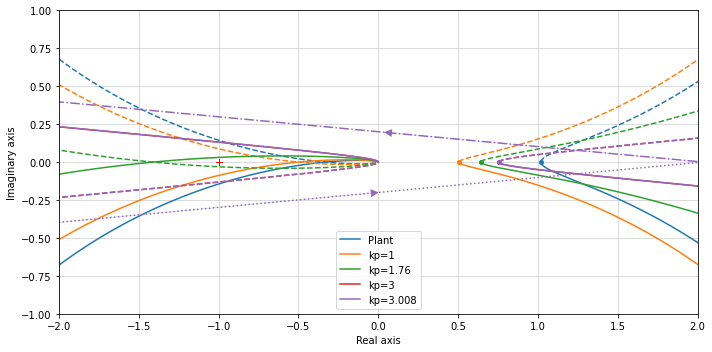

In [8]:
#ナイキスト線図
np=control.nyquist_plot(Plant, omega_limits=(0.01,1e3),omega_num=4096, plot=True)
for kp in kps:
  fbsys=control.feedback(Plant*tf([kp],[1]),1)
  np=control.nyquist_plot(fbsys, omega_limits=(0.01,1e3),omega_num=4096*2, plot=True)
pyplot.tight_layout()
axes=pyplot.gca()
axes.set_xlim(-2,2)
axes.set_ylim(-1,1)
lines=axes.lines
[l.set_label(leg) for l,leg in zip( (l for l in lines if l.get_ls() == "-"),
                                    ["Plant",]+[f"kp={kp}" for kp in kps])]
pyplot.gcf().set_size_inches(10,5)
pyplot.legend();pyplot.tight_layout()

# 限界感度法によるフィードバック
P制御されたモデルの時間応答／周波数応答をしらべることで、`kp=3.0`付近が限界感度であることが確認できました。
「Pythonによる制御工学入門」に従って限界感度法を使ったリスト5.12のゲインチューニングの結果を調べてみましょう。
PID制御のコントローラーの伝達関数を定義します。


In [9]:
T0=0.3
kp0=2.9
kp=0.2*kp0
ki=kp/(0.5 * T0)
kd=kp*(0.33 * T0)
print(kp,ki,kd)

PID_Cnt=tf([kd,kp,ki],[1,0])
PID_Cnt

0.58 3.8666666666666667 0.05742


TransferFunction(array([0.05742   , 0.58      , 3.86666667]), array([1, 0]))

このコントローラーを使ったフィードバックは、次のようになります。

In [10]:
fbsys=control.feedback(Plant*PID_Cnt)
print(fbsys.dcgain(), Plant.dcgain())
fbsys

1.0 1.019367991845054


TransferFunction(array([-5.74200000e+00,  2.23880000e+03,  2.28133333e+04,  1.54666667e+05]), array([1.00000000e+00, 3.95758000e+02, 2.93690000e+03, 6.20533333e+04,
       1.54666667e+05]))

### 限界感度法フィードバックの応答
それでは、限界感度法フィードバックを使ったシステムの時間応答、周波数応答をみてみましょう。


  -5.742 s^3 + 2239 s^2 + 2.281e+04 s + 1.547e+05
----------------------------------------------------
s^4 + 395.8 s^3 + 2937 s^2 + 6.205e+04 s + 1.547e+05



<Figure size 432x288 with 0 Axes>

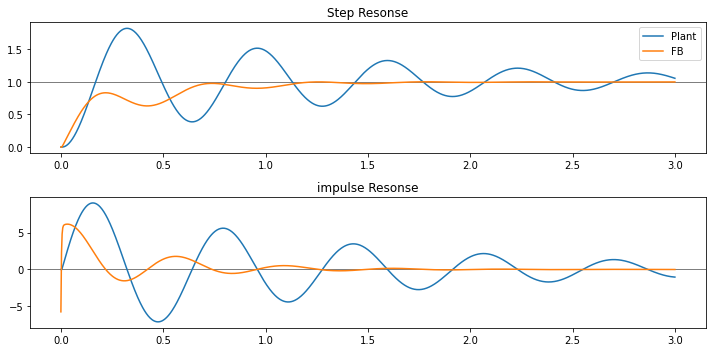

In [11]:
LimSenFB=fbsys 
print(fbsys)
pyplot.clf()
fig,axes=pyplot.subplots(2,1)
fig.set_size_inches(10,5)
axes[0].set_title("Step Resonse");axes[1].set_title("impulse Resonse");
axes[0].axhline(1, color="k", linewidth=0.5)
axes[1].axhline(0, color="k", linewidth=0.5)

T=linspace(0,3,1000)
sres=step_response(Plant,T,output=0)
ires=impulse_response(Plant,T,input=0)
axes[0].plot(sres.t,sres.y[0,0,:],label="Plant")
axes[1].plot(ires.t,ires.y[0,0,:])

#sres=step_response(fbsys,T,input=0,output=0)
sres=step_response(fbsys,T,output=0)
ires=impulse_response(fbsys,T,input=0)
axes[0].plot(sres.t,sres.y[0,0,:],label="FB")
axes[1].plot(ires.t,ires.y[0,0,:])
axes[0].legend()
fig.tight_layout()

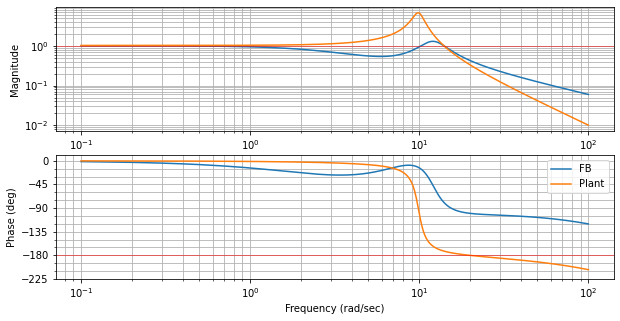

In [12]:
# bode線図を確認しましょう。

omega=linspace(0.1,1e2,1000)
bp=control.bode_plot(fbsys,omega,label="FB")
bp=control.bode_plot(Plant,omega,label="Plant")

pyplot.legend()
fig=pyplot.gcf()
axes=fig.axes
fig.set_size_inches(10,5)
axes[0].axhline(1, color="r", linewidth=0.5)
axes[1].axhline(-180, color="r", linewidth=0.5)

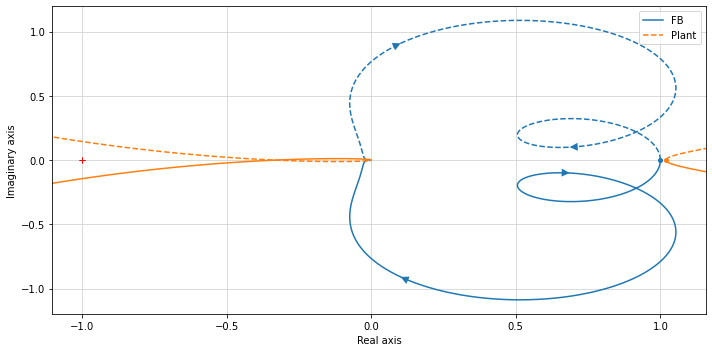

In [13]:
np=control.nyquist_plot(fbsys, omega_limits=(0.001,1e3),omega_num=10000, plot=True)
xlim=pyplot.gcf().axes[0].get_xlim()
ylim=pyplot.gcf().axes[0].get_ylim()
np=control.nyquist_plot(Plant, omega_limits=(0.001,1e3),omega_num=10000, plot=True)
pyplot.gcf().axes[0].set_xlim(xlim)
pyplot.gcf().axes[0].set_ylim(ylim)
lines=pyplot.gca().lines
[l.set_label(leg) for l,leg in zip(lines[::8],("FB","Plant"))]
pyplot.gcf().set_size_inches(10,5)
pyplot.legend();pyplot.tight_layout()

In [14]:
control.margin(LimSenFB), control.dcgain(LimSenFB)

((67.11139373729843,
  100.77077626786178,
  391.3017858416142,
  13.993743426305334),
 1.0)

# 状態空間へ
伝達関数を状態空間表示へ変換してみましょう。python/controlモジュールの`tf2ss`関数を使います。
伝達関数の分母の次数に応じて、状態空間の次数が決まります。極や零点の位置が変わらないこと、`ss2tf`を使って状態空間表示を伝達関数に変換すると元の伝達関数と等価な伝達関数に戻っていることなどが、確認できます。


In [15]:
SS=tf2ss(Plant,name="Plant")
dim_state=SS.nstates
# 極と零点の確認
print(SS, SS.poles(),SS.zeros(), SS.nstates)
print(eig(SS.A)[0])
#伝達関数がもとに戻ることを確認
print(ss2tf(SS).minreal(),Plant.minreal())

A = [[-4.01500000e+02  6.98100000e+00  3.92400000e+00]
     [-1.00000000e+02 -4.03482376e-15  3.20054605e-15]
     [ 0.00000000e+00  1.00000000e+02  2.40212604e-14]]

B = [[-0.1]
     [ 0. ]
     [ 0. ]]

C = [[  0. -10.  40.]]

D = [[0.]]
 [-400.  +0.j           -0.75+9.87610753j   -0.75-9.87610753j] [400.+0.j] 3
[-400.  +0.j           -0.75+9.87610753j   -0.75-9.87610753j]

           -100 s + 4e+04
-------------------------------------
s^3 + 401.5 s^2 + 698.1 s + 3.924e+04
 
           -100 s + 4e+04
-------------------------------------
s^3 + 401.5 s^2 + 698.1 s + 3.924e+04



## 可制御性／可観測性
このシステムの可制御性、可観測性を調べましょう。可制御行列(`control.ctrb()`),　可観測行列(`control.obsv()`)のランクが状態空間の次数(`SS.nstates`)と同じであれば、
それぞれ、可制御、可観測です。

In [16]:
#可制御？
numpy.linalg.matrix_rank(control.ctrb(SS.A,SS.B)) == SS.nstates

True

In [17]:
#可観測？
numpy.linalg.matrix_rank(control.obsv(SS.A,SS.C))==  SS.nstates

True

状態空間表示を直接物理的な運動方程式から導くこともできます。

運動方程式から、状態変数表示の状態方程式を導きます。入力のトルクは振り子の角度と単位が一致するように、スケールしておきます。


$$
\frac{d}{dt} \begin{bmatrix}\theta \\ \dot{\theta}\end{bmatrix} =  \begin{bmatrix} 0, & 1 \\  -\frac{M g l}{J},& -\frac{\mu}{J}\\ \end{bmatrix} \begin{bmatrix}\theta \\ \dot{\theta} \end{bmatrix} +\begin{bmatrix}0 \\ \frac{M g l}{J} \end{bmatrix}\theta_{ref}(t) 
$$
$$ 
\theta= \begin{bmatrix} 1,0\end{bmatrix} \begin{bmatrix}\theta \\ \dot{\theta}\end{bmatrix} + 0 \cdot \theta_{ref}(t)
$$

In [18]:
phym=ss([[0,1],[-Mgl/J, -mu/J]],
        [[0],[1/J]],
        [[1,0]],
        [[0]],
        name="physical model")
phym

<LinearIOSystem:physical model:['u[0]']->['y[0]']>

無駄時間の伝達関数も状態空間表示に書き換えます。

In [19]:
Delay=tf2ss(tf(num_delay,den_delay))
(Delay*phym).minreal()

StateSpace(array([[  21.8902988 ,   -6.43830182,    1.20106137],
       [  94.53480997,  -23.32780857,    4.85442209],
       [   0.        ,   -5.15310055, -400.06249024]]), array([[ 9.70138042],
       [-2.42553458],
       [ 0.        ]]), array([[ 0.        ,  0.        , -8.00062498]]), array([[0.]]))

伝達関数表示と状態空間表示のシステムを直接繋ぐことも可能です。

In [20]:
(tf(num_delay,den_delay)*phym).minreal()

StateSpace(array([[  21.8902988 ,   -6.43830182,    1.20106137],
       [  94.53480997,  -23.32780857,    4.85442209],
       [   0.        ,   -5.15310055, -400.06249024]]), array([[ 9.70138042],
       [-2.42553458],
       [ 0.        ]]), array([[ 0.        ,  0.        , -8.00062498]]), array([[0.]]))

この状態空間表示は、伝達関数から変換した状態空間表示とは異なっています。これらが等価であることを、それぞれのシステムを
`canonical_form`に変換して確認してみましょう。`canonical_form`は状態空間表示を等価な `reachable`, `observable`, `modal` のいずれかの
正準型に変換できます。ここでは"reachable"な正準型に変換してみましょう。

In [21]:
SS.minreal()

StateSpace(array([[-353.45629304,  -89.42271793,    3.51472151],
       [-194.16124253,  -24.5142952 ,   -5.16880334],
       [   0.        ,   97.19242142,  -23.52941176]]), array([[0.09683641],
       [0.02495417],
       [0.        ]]), array([[  0.        ,   0.        , -41.23105626]]), array([[0.]]))

In [22]:
SS_R, U_SS_R=control.canonical_form(SS,"observable")
SS_R

StateSpace(array([[-4.015e+02,  1.000e+00,  0.000e+00],
       [-6.981e+02,  0.000e+00,  1.000e+00],
       [-3.924e+04,  0.000e+00,  0.000e+00]]), array([[ 2.75617934e-15],
       [-1.00000000e+02],
       [ 4.00000000e+04]]), array([[1., 0., 0.]]), array([[0.]]))

In [23]:
PY_R, U_PY_R=control.canonical_form(Delay*phym,"observable")
PY_R

StateSpace(array([[-4.015e+02,  1.000e+00,  0.000e+00],
       [-6.981e+02,  0.000e+00,  1.000e+00],
       [-3.924e+04,  0.000e+00,  0.000e+00]]), array([[ 4.6040208e-16],
       [-1.0000000e+02],
       [ 4.0000000e+04]]), array([[1., 0., 0.]]), array([[0.]]))

と計算誤差を除いて、等価なシステムであることが確認できました。(このように、状態空間表示では、同じ入出力関係を与える無数の等価な状態空間が可能です。フィードバックの最適化において、
状態空間表示の選び方によらないパラメータの指定方法については、後述の「等価な状態空間を用いた解析」セクションをご覧ください。


#　状態フィードバック
可制御なシステムでは、状態フィードバック法を使うことで、”最適"フィードバックを実現できることが知られています。

状態フィードバック法では、制御則として、

$$
 u= -K X
$$

を使います。制御対称システムが可制御である時、適当なフィードバックゲイン $K$　を選択することで、$A - B K$の全ての固有値の実数部分を負にすることができることが証明されています。
このような$K$を `place()`や`acker()`を用いて求めることができます。

また、 $\int_0^{\infty} dt \left[X^T Q X + u^t R u + 2 u^T N X \right]$ を最小にする”最適フィードバック"係数を、Ricatti 方程式の解を用いて、求めるための
`control.lqr()`関数が用意されています。

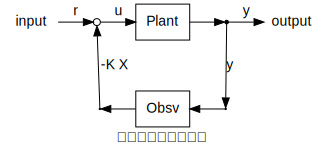

In [24]:
"""
## control.feedback(Sys1,Sys2,sign)
"""
#pip install -U graphviz
import graphviz
g=graphviz.Digraph("G", graph_attr={"rankdir":"TB","rank":"same"},engine="dot") # or circo
g.attr(fontname="Helvetica,Arial,sans-serif")
g.attr(label="状態フィードバック")
#g.attr(orientation="L")

g.attr("node",fontname="Helvetica,Arial,sans-serif")
g.attr("edge",fontname="Helvetica,Arial,sans-serif")

g.node("input", shape="plaintext")
g.node("mixer", label="", shape="ellipse", height="0.1", width="0.1",)
g.node("output", shape="plaintext")
g.node("splitter", label="", shape="point", height="0.05", width="0.05")
g.node("corner1", label="", shape="point", height="0.02", width="0.02")
g.node("corner2", label="", shape="point", height="0.02", width="0.02")

g.node("Plant",shape="box")
g.node("Obsv",shape="box")

with g.subgraph(name="upper") as sg:
  sg.graph_attr['rankdir']='LR'
  sg.graph_attr['rank']='same'
  sg.edge("input","mixer", label="r")
  sg.edge("mixer","Plant", label="u")
  sg.edge("Plant","splitter")
  sg.edge("splitter","output",label="y")
  
g.edge("splitter","corner2",label="y")
g.edge("corner1","mixer",label=" -K X")

with g.subgraph(name="lower") as sg:
  sg.attr("graph",rankdir="LR",rank="same")
  sg.edge("Obsv","corner2",dir="back")
  sg.edge("corner1","Obsv",dir="back")
g

In [25]:
G=[[1,0,0]]@control.obsv(SS.A,SS.C)
G

array([[  0., -10.,  40.]])

In [26]:
# 状態フィードバックゲイン
# Qとして　システムの可観測行列を使って、重み行列Qをパラーメータ化します。これによって、状態空間表示の選び方によらず、
# 同じ状態フィードバックを実現するゲインを求めることができます。、
# 以下の選択は、$\int dt y^{T} y $を最小化するのと等価。
Qw=10
G=diag([1,0,0])@control.obsv(SS.A,SS.C)
Qo=eye(SS.nstates) # 
Q=G.transpose()@Qo@G
# print(Q-Q.transpose()) # check if Q is symmetric

K,P,e_K=control.lqr(SS.A, SS.B, Q ,diag([1/Qw]))

K=matrix(K) # あるいは、行列としての積がが必要なところで、numpy.matmul（演算子　＠)を使う。
K, e_K, eig(SS.A-numpy.matmul(SS.B,K))[0], numpy.linalg.det(SS.A-numpy.matmul(SS.B,K))

(matrix([[-201.38833773,  828.85280729,   93.19782541]]),
 array([-400.       +0.j      ,  -10.819417+14.629928j,
         -10.819417-14.629928j], dtype=complex64),
 array([-400.         +0.j        ,  -10.81941689+14.62992761j,
         -10.81941689-14.62992761j]),
 -132437.82541304035)

#### ackerとplace関数
ackerとplaceをそれぞれ使って、コントローラーのゲインをもちめてみます。

In [27]:
control.acker(SS.A,SS.B, [-400.  ,  -10.819417+14.629928j, - 10.819417-14.629928j])

array([[-201.38834   ,  828.85281775,   93.197831  ]])

In [28]:
control.place(SS.A,SS.B, [-400.  ,  -10.819417+14.629928j, - 10.819417-14.629928j ])

array([[-201.38834   ,  828.85281775,   93.197831  ]])

状態フィードバックでは、それぞれの時点での状態空間の状態変数が必要ですが、これは直接測定できません。可観測なシステムでは
、状態推定樹を構成して観測値から除隊ベクトルwp

In [29]:
#推定器ゲイン
Gw=10
G=matmul(control.ctrb(SS.A, SS.B),diag([1,0,0]))
H,P,e_H=control.lqe(SS.A, 
                  #SS.nstates*[[1]],
                  Gw*G,
                  SS.C, 
                  diag([1,1,1]),
                  diag([1]))
H=matrix(H) # あとで、行列としての演算が必要なのでarrayではなく、matrixにしておく。
print("H^{T} =",H.transpose(),"\ne_H:", e_H)

H^{T} = [[0.01370951 0.20783127 1.0797191 ]] 
e_H: [-400.       +0.j        -21.305225+23.470995j  -21.305225-23.470995j]


In [30]:
# ObsvはPlantからの出力　:math:`y` を入力として、フィードバック用の出力　:math:`u`を出力する。
# この推定器だと、元のシステムで入力が0の場合の動作しか推定していない。
Obsv=control.ss(
  SS.A - numpy.matmul(H,SS.C) - numpy.matmul(SS.B, K), H,
  -K , numpy.matrix([0]))
Obsv.name="Observer"
Obsv

<LinearIOSystem:Observer:['u[0]']->['y[0]']>

## 状態推定器付き状態フィードバック
推定器と状態フィードバックを組み合わせたフィードバックの時間応答（step_response/impulse_response)をみてみます。

In [31]:
fbsys=SS.feedback(Obsv,1) 
print("dcgain:",fbsys.dcgain())
# 出力はSSの出力。入力も　SSと同じ (u)
#fbsys=control.feedback(SS,Obsv,1) # same as above
#以下は似ているが違うシステム
#fbsys=control.feedback(Obsv*SS,1,1)　# 出力は　u
#fbsys=control.feedback(SS*Obsv,1,1) # 出力は　y 、入力は　y
#fbsys=(SS*Obsv).feedback(1,1) # 　入力は 観測値yで出力もy
#fbsys=(Obsv*SS).feedback(1,1) # 入力はuで出力は u
# 分離定理が成り立っていることの確認
#print(e_K,"\n", e_H,"\n",
#      numpy.linalg.eig(fbsys.A)[0]
#     )
#print(numpy.concatenate([
#  eig(SS.A-numpy.matmul(SS.B,K))[0],
#  eig(SS.A-numpy.matmul(H,SS.C))[0]],
#  0),"\n",
#  numpy.linalg.eig(fbsys.A)[0]
#)

dcgain: 0.6612086261050192


<Figure size 432x288 with 0 Axes>

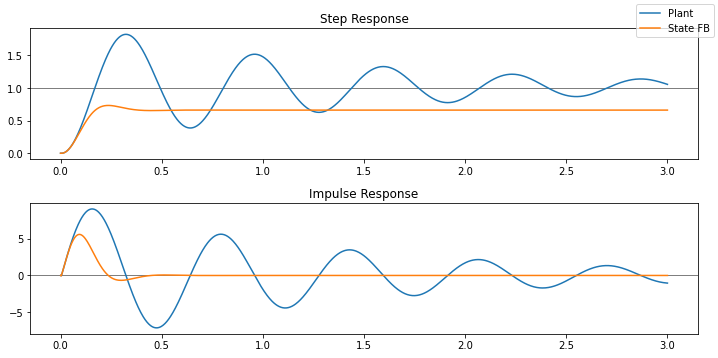

In [32]:
pyplot.clf()
fig,axes=pyplot.subplots(2,1)
fig.set_size_inches(10,5)
axes[0].set_title("Step Response")
axes[1].set_title("Impulse Response")
axes[0].axhline(1,color="black",linewidth=0.5)
axes[1].axhline(0,color="black",linewidth=0.5)
fig.tight_layout()

r0=0
T=linspace(0,3,1000)

sres=step_response(SS,T,r0)
ires=impulse_response(SS,T)
axes[0].plot(sres.t,sres.y[0,0,:],label="Plant")
axes[1].plot(ires.t,ires.y[0,0,:])

sres=step_response(fbsys,T,r0)
ires=impulse_response(fbsys,T)
axes[0].plot(sres.t,sres.y[0,0,:],label="State FB")
axes[1].plot(ires.t,ires.y[0,0,:])

fig.legend()

状態フィードバックのDCゲインが1ではないので、さらに外側にフィードバックをかけてDCゲインが1になるようにしてみましょう。

1.0000000000000007


<Figure size 432x288 with 0 Axes>

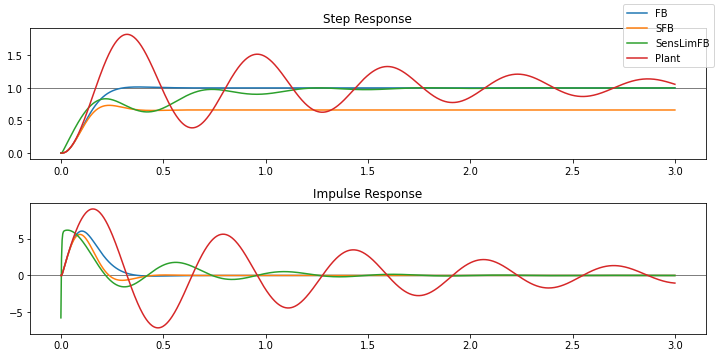

In [33]:
FFB=fbsys.feedback(-(1-fbsys.dcgain())/fbsys.dcgain())
#kp=(1-fbsys.dcgain())/fbsys.dcgain()
#ki=0
#PIFB=control.tf([kp,ki],[1,0])
#FFB=(fbsys*PIFB).feedback()

print(FFB.dcgain())
#FFB=fbsys.feedback(-0.001)

pyplot.clf()
fig,axes=pyplot.subplots(2,1)
pyplot.gcf().set_size_inches(10,5)
axes[0].axhline(1,color="black",linewidth=0.5)
axes[1].axhline(0,color="black",linewidth=0.5)
axes[0].set_title("Step Response")
axes[1].set_title("Impulse Response")

sres=step_response(FFB,T)
ires=impulse_response(FFB,T,)
axes[0].plot(sres.t,sres.y[0,0,:],label="FB")
axes[1].plot(ires.t,ires.y[0,0,:])

sres=step_response(fbsys,T)
ires=impulse_response(fbsys,T,)
axes[0].plot(sres.t,sres.y[0,0,:],label="SFB")
axes[1].plot(ires.t,ires.y[0,0,:])

sres=step_response(LimSenFB,T)
ires=impulse_response(LimSenFB,T,)
axes[0].plot(sres.t,sres.y[0,0,:],label="SensLimFB")
axes[1].plot(ires.t,ires.y[0,0,:])

sres=step_response(SS,T)
ires=impulse_response(SS,T,)
axes[0].plot(sres.t,sres.y[0,0,:],label="Plant")
axes[1].plot(ires.t,ires.y[0,0,:])


fig.legend()
fig.tight_layout()

これらのシステムはSISOシステムなので、`bode_plot`を使って、bode図を作成してみます。

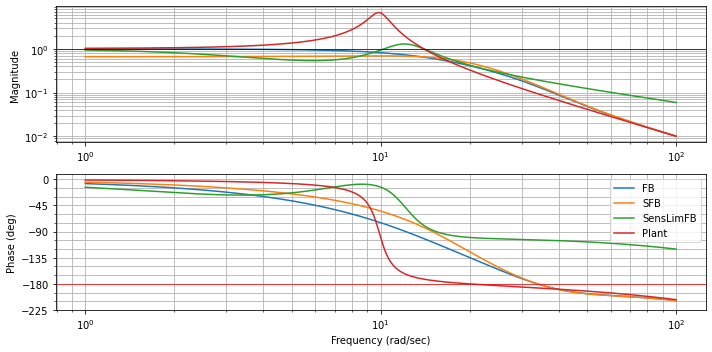

In [34]:
omega=linspace(1,1e2,4000)
bp=control.bode_plot(FFB,omega,label="FB")
bp=control.bode_plot(fbsys,bp[2],label="SFB")
bp=control.bode_plot(LimSenFB,bp[2],label="SensLimFB")
bp=control.bode_plot(SS,omega,label="Plant")
pyplot.gcf().axes[0].axhline(1,color="black",linewidth=0.7)
pyplot.gcf().axes[1].axhline(-180,color="red",linewidth=0.7)

pyplot.gcf().set_size_inches(10,5)
pyplot.gcf().axes[1].legend();pyplot.tight_layout()

## ナイキスト線図の作成
ナイキスト線図の作成には、`nyquist_plot()`関数を使います。

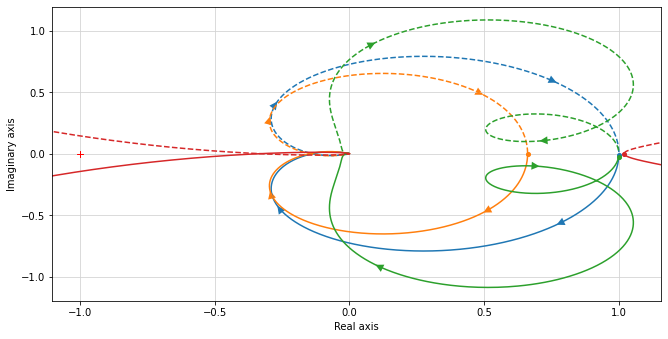

In [35]:
#omega=linspace(0.1,1e2,4000)
omega=numpy.logspace(-1,3,4000)
np=control.nyquist_plot(FFB,omega, plot=True)
np=control.nyquist_plot(fbsys, omega, plot=True)
np=control.nyquist_plot(LimSenFB, omega, plot=True)
xlim=pyplot.gcf().axes[0].get_xlim()
ylim=pyplot.gcf().axes[0].get_ylim()
np=control.nyquist_plot(SS, omega_limits=(0.1,1e3),omega_num=4000, plot=True)
pyplot.gcf().axes[0].set_xlim(xlim)
pyplot.gcf().axes[0].set_ylim(ylim)
pyplot.tight_layout()
pyplot.gcf().set_size_inches(10,5)

(array([-399.99999966 +0.j        , -400.00000034 +0.j        ,
        -10.81941689+14.62992761j,  -10.81941689-14.62992761j,
        -21.30522569+23.47099576j,  -21.30522569-23.47099576j]), array([-400.39058452 +0.j        ,  -31.17935032+35.00624191j,
        -31.17935032-35.00624191j,  400.         +0.j        ]))


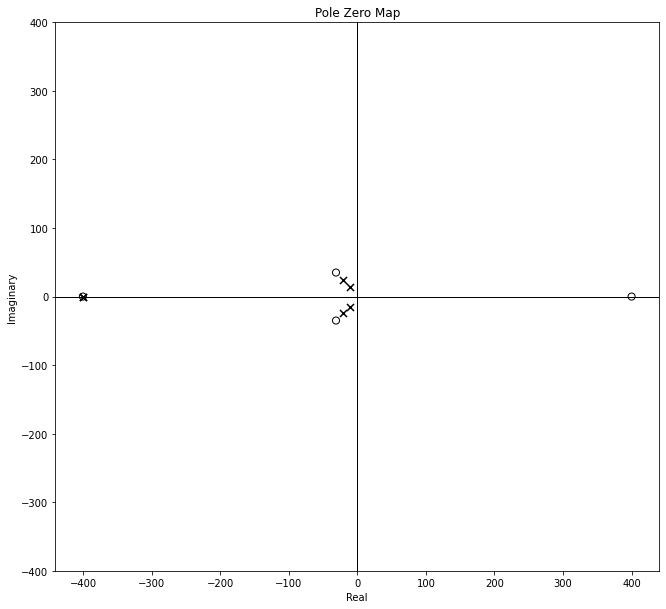

In [36]:
# plot locations of the polrs and zeros in the complex s plain.
print(control.pzmap(fbsys))
fig=pyplot.gcf()
fig.tight_layout();fig.set_size_inches((10,10))

## 制御対象への入力に追従する状態推定器を構成する。
状態推定器に入力　$u$ を伝えるため、出力に $u$を追加する。
プラントを状態空間へ変換するだけでなく、制御値 $u$ と出力の目標値　$r$　を出力として持つ、状態空間に拡張することが必要です。

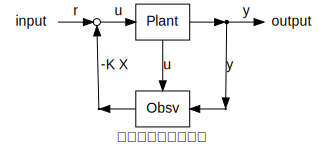

In [37]:
"""
## control.feedback(Sys1,Sys2,sign)
"""
#pip install -U graphviz
import graphviz
g=graphviz.Digraph("G", graph_attr={"rankdir":"TB","rank":"same"},engine="dot") # or circo
g.attr(fontname="Helvetica,Arial,sans-serif")
g.attr(label="状態フィードバック")

#g.attr(orientation="L")

g.attr("node",fontname="Helvetica,Arial,sans-serif")
g.attr("edge",fontname="Helvetica,Arial,sans-serif")

g.node("input", shape="plaintext")
g.node("mixer", label="", shape="ellipse", height="0.1", width="0.1",)
g.node("output", shape="plaintext")
g.node("splitter", label="", shape="point", height="0.05", width="0.05")
g.node("corner1", label="", shape="point", height="0.02", width="0.02")
g.node("corner2", label="", shape="point", height="0.02", width="0.02")

g.node("Plant",shape="box")
g.node("Obsv",shape="box")

with g.subgraph(name="upper") as sg:
  sg.graph_attr['rankdir']='LR'
  sg.graph_attr['rank']='same'
  sg.edge("input","mixer", label="r")
  sg.edge("mixer","Plant", label="u")
  sg.edge("Plant","splitter")
  sg.edge("splitter","output",label="y")
  
g.edge("splitter","corner2",label="y")
g.edge("corner1","mixer",label=" -K X")
g.edge("Plant","Obsv",label="u")

with g.subgraph(name="lower") as sg:
  sg.attr("graph",rankdir="LR",rank="same")
  sg.edge("Obsv","corner2",dir="back")
  sg.edge("corner1","Obsv",dir="back")
g

In [38]:
#拡張された 状態空間
SSe=ss(SS.A, SS.B,
       numpy.concatenate([SS.C,[SS.nstates*[0]]],0),
       numpy.concatenate([SS.D,[[1]]],0)) # 出力に u を加える。

In [39]:
SSe

<LinearIOSystem:sys[174]:['u[0]']->['y[0]', 'y[1]']>

In [40]:
#SSeからのuを使う オブザーバ を定義します。状態推定器のゲインは同じものを使います。
Obsv_e=control.ss(
  SSe.A - H*SS.C, 
  numpy.concatenate([H, SS.B - numpy.matmul(H,SS.D)], 1),
  -K , 
  numpy.matrix([[0,0]]))
Obsv_e

<LinearIOSystem:sys[175]:['u[0]', 'u[1]']->['y[0]']>

In [41]:
fbsys_e=SSe.feedback(Obsv_e, 1) # 出力はSSの出力+u。入力も　SS_eと同じ (u)
#固有値の確認
print(eig(SS.A - numpy.matmul(SS.B, K))[0],"\n",
      eig(SS.A - numpy.matmul(H, SS.C))[0],"\n",
      numpy.linalg.eig(fbsys_e.A)[0]
     )
fbsys_e

[-400.         +0.j          -10.81941689+14.62992761j
  -10.81941689-14.62992761j] 
 [-400.         +0.j          -21.30522569+23.47099576j
  -21.30522569-23.47099576j] 
 [-399.99999966 +0.j         -400.00000034 +0.j
  -10.81941689+14.62992761j  -10.81941689-14.62992761j
  -21.30522569+23.47099576j  -21.30522569-23.47099576j]


<LinearICSystem:sys[176]:['u[0]']->['y[0]', 'y[1]']>

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/control/timeresp.py:1812: UserWarning: System has direct feedthrough: ``D != 0``. The infinite impulse at ``t=0`` does not appear in the output.
Results may be meaningless!
  warnings.warn("System has direct feedthrough: ``D != 0``. The "


<Figure size 432x288 with 0 Axes>

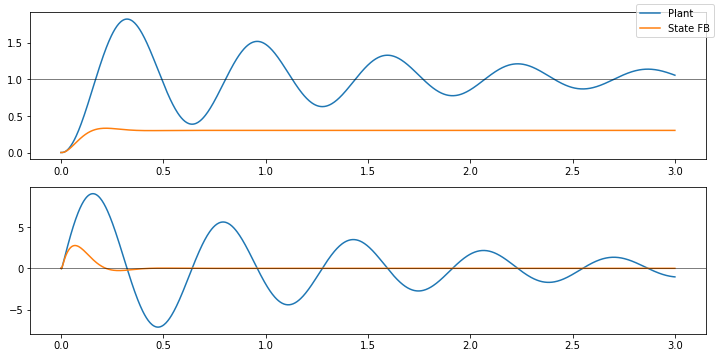

In [42]:
T=linspace(0,3,1000)
pyplot.clf()
fig,axes=pyplot.subplots(2,1)
pyplot.gcf().set_size_inches(10,5)

#r0=-0.0001/4
r0=0.1
sres=step_response(SS,T)
ires=impulse_response(SS,T)
axes[0].plot(sres.t,sres.y[0,0,:],label="Plant")
axes[1].plot(ires.t,ires.y[0,0,:])

sres=step_response(fbsys_e,T,output=0,input=0)
ires=impulse_response(fbsys_e,T,output=0,input=0)
axes[0].plot(sres.t,sres.y[0,0,:], label="State FB")
axes[1].plot(ires.t,ires.y[0,0,:])
axes[0].axhline(1.0,color='black',linewidth=0.5)
axes[1].axhline(0.0,color='black',linewidth=0.5)

fig.legend();fig.tight_layout()

In [43]:
#DC gain: -> .dcgain(): .dcgain()の結果と、平衡値の理論式との比較
print("DC gain:",fbsys_e.dcgain().transpose()[0])
# r -> y, r->u
( (-matrix(SS.C-matmul(SS.D,K))*matrix(SS.A-matmul(SS.B,K))**(-1)*SS.B + SS.D)[0,0], #r->y
 (1+K*matrix(SS.A-matmul(SS.B,K))**(-1)*SS.B )[0,0])# r-> u

DC gain: [0.30202852 0.29628998]


(0.30202851696824545, 0.296289975145847)

<Figure size 432x288 with 0 Axes>

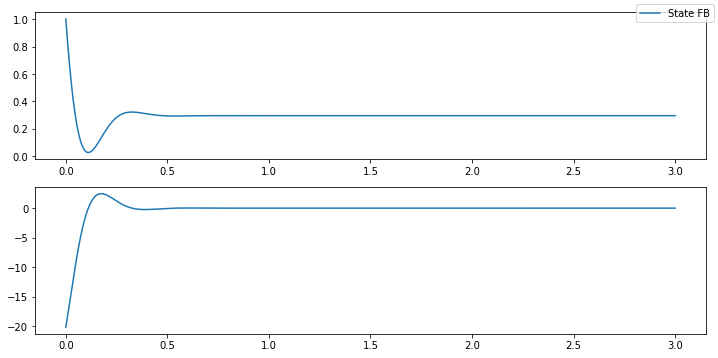

In [44]:
#出力の応答も見てみましょう
pyplot.clf()
fig,axes=pyplot.subplots(2, 1)
pyplot.gcf().set_size_inches(10,5)

sres=step_response(fbsys_e, T, output=1, input=0)
ires=impulse_response(fbsys_e, T, output=1, input=0)
axes[0].plot(sres.t, sres.y[0,0,:], label="State FB")
axes[1].plot(ires.t, ires.y[0,0,:])
fig.legend();fig.tight_layout()

状態フィードバックだけでは、状態を0とするようにフィードバックが働くので、dcgainが1より小さくなっている。
この外側にP制御を追加してDCgainが1になるよう調整してみます。

In [45]:
# 1 loop correction
# DC gain for u
#dcgain=-SS.C*matrix(SS.A-numpy.matmul(SS.B,K))**(-1)*SS.B
dcgain=fbsys_e.dcgain()[0,0]
FFB=fbsys_e.feedback(ss([],[],[], [1,0]), (1-dcgain)/dcgain) # positive feedback 
print(f"{dcgain=}")
print(f"{FFB.dcgain()[0][0]=}")

dcgain=0.30202851696824606
FFB.dcgain()[0][0]=0.9999999999999366


<Figure size 432x288 with 0 Axes>

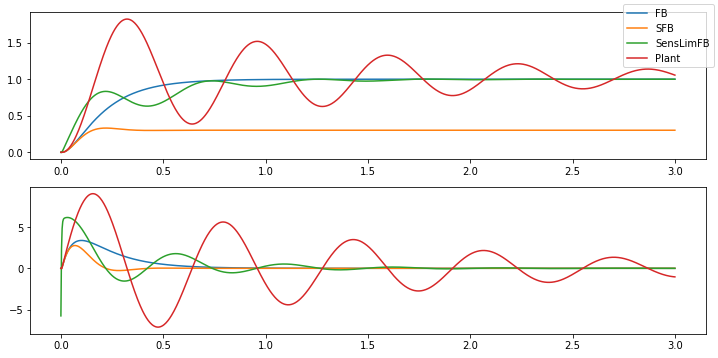

In [46]:
pyplot.clf()
fig,axes=pyplot.subplots(2,1)
pyplot.gcf().set_size_inches(10,5)

sres=step_response(FFB,T)
ires=impulse_response(FFB,T,)
axes[0].plot(sres.t,sres.y[0, 0,:],label="FB")
axes[1].plot(ires.t,ires.y[0, 0,:])

sres=step_response(fbsys_e,T)
ires=impulse_response(fbsys_e,T,)
axes[0].plot(sres.t,sres.y[0,0,:],label="SFB")
axes[1].plot(ires.t,ires.y[0,0,:])

sres=step_response(LimSenFB,T)
ires=impulse_response(LimSenFB,T,)
axes[0].plot(sres.t,sres.y[0,0,:],label="SensLimFB")
axes[1].plot(ires.t,ires.y[0,0,:])

sres=step_response(SS,T)
ires=impulse_response(SS,T,)
axes[0].plot(sres.t,sres.y[0,0,:],label="Plant")
axes[1].plot(ires.t,ires.y[0,0,:])
fig.legend()
fig.tight_layout()

<Figure size 432x288 with 0 Axes>

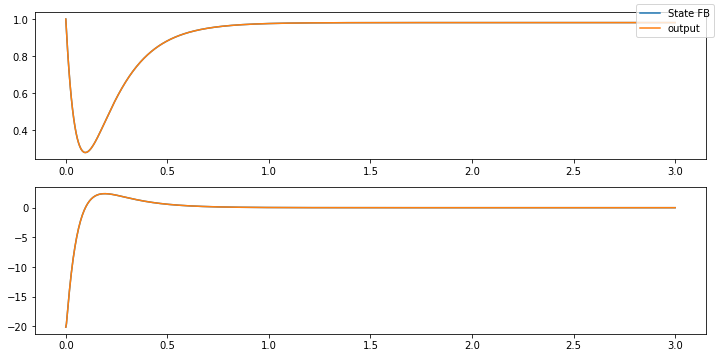

In [47]:
#出力の応答も見てみましょう
pyplot.clf()
fig,axes=pyplot.subplots(2, 1)
pyplot.gcf().set_size_inches(10,5)

sres=step_response(FFB, T, output=1, input=0)
ires=impulse_response(FFB, T, output=1, input=0)
axes[0].plot(sres.t, sres.y[0,0,:], label="State FB") # step
axes[0].plot(sres.t, sres.outputs, label="output") # step
axes[1].plot(ires.t, ires.y[0,0,:])
axes[1].plot(ires.t, ires.outputs[:])
fig.legend();fig.tight_layout()

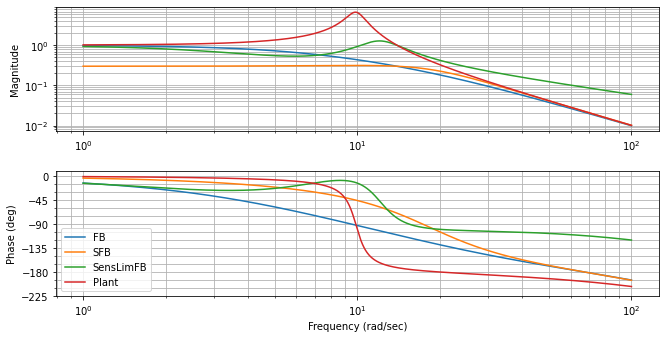

In [48]:
#omega=linspace(1,1e2,4000)
omega=numpy.logspace(0,2,4000)
bp=control.bode_plot(ss([],[],[], [1,0])*FFB,omega,label="FB")
bp=control.bode_plot(ss([],[],[], [1,0])*fbsys_e,bp[2],label="SFB")
bp=control.bode_plot(LimSenFB,bp[2],label="SensLimFB")
bp=control.bode_plot(SS,omega,label="Plant")
pyplot.legend();pyplot.tight_layout()
pyplot.gcf().set_size_inches(10,5)

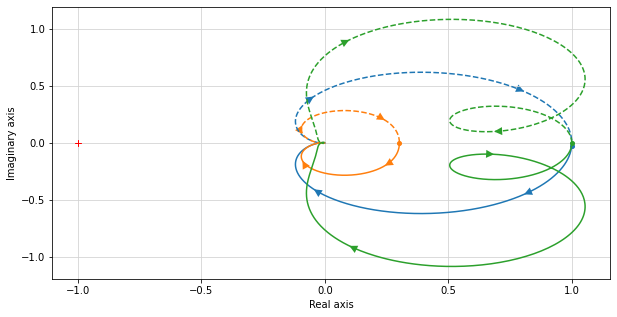

In [49]:
omega=numpy.logspace(0,2,4000)
np=control.nyquist_plot(ss([],[],[], [1,0])*FFB, omega_limits=(0.1,1e3),omega_num=4000, plot=True)
np=control.nyquist_plot(ss([],[],[], [1,0])*fbsys_e, omega_limits=(0.1,1e3),omega_num=4000, plot=True)
np=control.nyquist_plot(LimSenFB, omega_limits=(0.001,1e3),omega_num=4096, plot=True)
pyplot.gcf().set_size_inches(10,5)

# 外乱オブザーバを使ったフィードバックを構成する。
外乱オブザーバ(「Pythonによる制御工学入門」Page. 233 ) を使った制御システムを作ってみます。
外乱オブザーバを使ったシステムは、入力 $u$ に対するDCgainは元のプラントと同じになることも確認してみます。

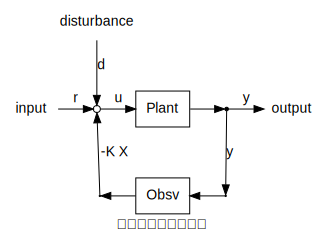

In [50]:
"""
## control.feedback(Sys1,Sys2,sign)
"""
#pip install -U graphviz
import graphviz
g=graphviz.Digraph("G", graph_attr={"rankdir":"TB","rank":"same"},engine="dot") # or circo
g.attr(fontname="Helvetica,Arial,sans-serif")
g.attr(label="外乱フィードバック")

#g.attr(orientation="L")

g.attr("node",fontname="Helvetica,Arial,sans-serif")
g.attr("edge",fontname="Helvetica,Arial,sans-serif")

g.node("input", shape="plaintext")
g.node("mixer", label="", shape="ellipse", height="0.1", width="0.1",)
g.node("output", shape="plaintext")
g.node("splitter", label="", shape="point", height="0.05", width="0.05")
g.node("corner1", label="", shape="point", height="0.02", width="0.02")
g.node("corner2", label="", shape="point", height="0.02", width="0.02")

g.node("Plant",shape="box")
g.node("Obsv",shape="box")

with g.subgraph(name="upper") as sg:
  sg.graph_attr['rankdir']='LR'
  sg.graph_attr['rank']='same'
  sg.node("disturbance", shape="plaintext")

with g.subgraph(name="middle") as sg:
  sg.graph_attr['rankdir']='LR'
  sg.graph_attr['rank']='same'
  sg.edge("input","mixer", label="r")
  sg.edge("mixer","Plant", label="u")
  sg.edge("Plant","splitter")
  sg.edge("splitter","output",label="y")
  
g.edge("splitter","corner2",label="y")
g.edge("corner1","mixer",label=" -K X")
g.edge("disturbance","mixer",label="d")

with g.subgraph(name="lower") as sg:
  sg.attr("graph",rankdir="LR",rank="same")
  sg.edge("Obsv","corner2",dir="back")
  sg.edge("corner1","Obsv",dir="back")
g

In [51]:
# 外乱オブザーバ のあるシステムでのObserver gainを求めてみる。
Target=SS
# 状態空間の切り替えにうまく対応できていない。
PhyM=ss(delay_tf*phym)
#PhyM=control.canonical_form(delay_tf*phym,"observable")[0].minreal()
#Target=PhyM 
Q=matmul(Target.C.transpose(),Target.C)
K_T,*result=control.lqr(Target.A, Target.B, Q ,diag([1/Qw]))

Ad=numpy.concatenate( 
  ( numpy.concatenate( (Target.A - matmul(Target.B, K_T), numpy.zeros((Target.nstates,1))),1),
    numpy.zeros((1,Target.nstates+1))
  ),
  0
)
Bd=numpy.concatenate(
  (
   (Target.B, 
    [[0]])
  )
  ,0
)
Cd=numpy.concatenate((Target.C, [[1]]),1)
Dd=numpy.zeros((1,1))
print("Observable?", matrix_rank(control.obsv(Ad,Cd))== Target.nstates+1)# observable!
print("Controllable?",matrix_rank(control.ctrb(Ad,Bd))== Target.nstates+1)# not cntrolable 

gamma=0.0
G=(Target.nstates+1)*[[1]]
G=Bd
G[-1]=[1]
for beta in ( 0.1,1,10,100):# weight parameter for disturbance in $G$
  print("Hd for beta={}\n".format(beta), 
        control.lqe(Ad, beta*G, Cd, diag([1]) ,diag([1]))[0])

# 状態変数と外乱の推定器ゲインを求める。 外乱推定を行わない推定器のゲイン＄H$を使っても大きな違いは出ない。
beta=20
g=30
G=Bd
G=beta*G
G[-1]=[g]
print("Controllable?",matrix_rank(control.ctrb(Ad,G))== Target.nstates+1)# this case is contrallable.
Hd,*rest=control.lqe(Ad, G, Cd, diag([1]) ,diag([1]))
Hd, matmul(Hd,Cd), matmul(H,Target.C)

Observable? True
Controllable? False
Hd for beta=0.1
 [[ 5.46878986e-06]
 [-1.10671082e-06]
 [ 2.47892393e-04]
 [ 1.00000000e-01]]
Hd for beta=1
 [[5.28218075e-04]
 [1.88341753e-04]
 [2.22379888e-02]
 [1.00000000e+00]]
Hd for beta=10
 [[ 0.01253813]
 [ 0.08939591]
 [ 0.49702284]
 [10.        ]]
Hd for beta=100
 [[ -1.36229129]
 [  1.69987341]
 [  1.53696267]
 [100.        ]]
Controllable? True


(array([[-0.04663812],
        [ 0.2819605 ],
        [ 0.70396577],
        [30.        ]]),
 array([[ 0.00000000e+00,  4.66381206e-01, -1.86552482e+00,
         -4.66381206e-02],
        [ 0.00000000e+00, -2.81960501e+00,  1.12784200e+01,
          2.81960501e-01],
        [ 0.00000000e+00, -7.03965768e+00,  2.81586307e+01,
          7.03965768e-01],
        [ 0.00000000e+00, -3.00000000e+02,  1.20000000e+03,
          3.00000000e+01]]),
 matrix([[  0.        ,  -0.13709513,   0.54838054],
         [  0.        ,  -2.07831273,   8.31325093],
         [  0.        , -10.79719103,  43.18876412]]))

In [52]:
## 外乱オブザーバを定義します。
Obsv_d=control.ss(
  Ad - matmul(Hd, Cd),
  Hd,
  numpy.concatenate((K_T, [[gamma]]),1) , numpy.matrix([[0]]),
  name="Obsv_d"
)
print(Obsv_d)

<LinearIOSystem>: Obsv_d
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[-4.21638834e+02  8.93998995e+01  1.51093074e+01  4.66381206e-02]
     [-1.00000000e+02  2.81960501e+00 -1.12784200e+01 -2.81960501e-01]
     [ 0.00000000e+00  1.07039658e+02 -2.81586307e+01 -7.03965768e-01]
     [ 0.00000000e+00  3.00000000e+02 -1.20000000e+03 -3.00000000e+01]]

B = [[-0.04663812]
     [ 0.2819605 ]
     [ 0.70396577]
     [30.        ]]

C = [[-201.38833773  828.85280729   93.19782541    0.        ]]

D = [[0.]]



In [53]:
fbsys_d=Target.feedback(Obsv_d) # 出力はSSの出力+u。入力も　SS_eと同じ (u)
fbsys_d.name="fbsys_d"
fbsys_d

StateSpace(array([[-4.01500000e+02,  6.98100000e+00,  3.92400000e+00,
        -2.01388338e+01,  8.28852807e+01,  9.31978254e+00,
         0.00000000e+00],
       [-1.00000000e+02, -4.03482376e-15,  3.20054605e-15,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+02,  2.40212604e-14,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  4.66381206e-01, -1.86552482e+00,
        -4.21638834e+02,  8.93998995e+01,  1.51093074e+01,
         4.66381206e-02],
       [ 0.00000000e+00, -2.81960501e+00,  1.12784200e+01,
        -1.00000000e+02,  2.81960501e+00, -1.12784200e+01,
        -2.81960501e-01],
       [ 0.00000000e+00, -7.03965768e+00,  2.81586307e+01,
         0.00000000e+00,  1.07039658e+02, -2.81586307e+01,
        -7.03965768e-01],
       [ 0.00000000e+00, -3.00000000e+02,  1.20000000e+03,
         0.00000000e+00,  3.00000000e+02, -1.20000000e+03,
       

In [54]:
print(tf(fbsys_d.minreal()))
fbsys_d.dcgain()


              -100 s^5 - 7698 s^4 + 1.574e+07 s^3 + 1.22e+09 s^2 + 4.595e+10 s + 1.589e+11
--------------------------------------------------------------------------------------------------------
s^7 + 878.5 s^6 + 2.256e+05 s^5 + 1.491e+07 s^4 + 5.11e+08 s^3 + 8.654e+09 s^2 + 8.396e+10 s + 1.559e+11



1.0193679918449612

In [55]:
print(fbsys_d.poles(),"\n",fbsys_d.zeros())

[-400.         +0.j         -400.33306731 +0.j
  -27.0760555 +22.7187251j   -27.0760555 -22.7187251j
  -10.81941689+14.62992761j  -10.81941689-14.62992761j
   -2.35384738 +0.j        ] 
 [-400.79149195 +0.j         -36.17870477+35.7786829j
  -36.17870477-35.7786829j   -3.82895798 +0.j
  400.         +0.j       ]


In [56]:
print(fbsys_e.poles(),"\n",fbsys_e.zeros())

[-399.99999966 +0.j         -400.00000034 +0.j
  -10.81941689+14.62992761j  -10.81941689-14.62992761j
  -21.30522569+23.47099576j  -21.30522569-23.47099576j] 
 [ -21.30522569+23.47099576j  -21.30522569-23.47099576j
 -400.         +0.j        ]


In [57]:
# 外乱オブザーバを入れた時に期待される DCgain(次の節参照）
-Target.C*matrix(Target.A)**(-1)*Target.B

matrix([[1.01936799]])

In [58]:
for s in (fbsys_d, fbsys_e, FFB, LimSenFB, Target):
  print(s.name, s.dcgain(),"\n\t",s.poles())

fbsys_d 1.0193679918449612 
	 [-400.         +0.j         -400.33306731 +0.j
  -27.0760555 +22.7187251j   -27.0760555 -22.7187251j
  -10.81941689+14.62992761j  -10.81941689-14.62992761j
   -2.35384738 +0.j        ]
sys[176] [[0.30202852]
 [0.29628998]] 
	 [-399.99999966 +0.j         -400.00000034 +0.j
  -10.81941689+14.62992761j  -10.81941689-14.62992761j
  -21.30522569+23.47099576j  -21.30522569-23.47099576j]
sys[183] [[1.   ]
 [0.981]] 
	 [-398.77529207 +0.j         -400.         +0.j
  -21.30522569+23.47099576j  -21.30522569-23.47099576j
   -5.92012251 +0.j          -16.94341919 +0.j        ]
sys[107] 1.0 
	 [-388.6087963  +0.j           -2.21733464+11.90386149j
   -2.21733464-11.90386149j   -2.71453442 +0.j        ]
Plant 1.0193679918450622 
	 [-400.  +0.j           -0.75+9.87610753j   -0.75-9.87610753j]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/control/timeresp.py:1812: UserWarning: System has direct feedthrough: ``D != 0``. The infinite impulse at ``t=0`` does not appear in the output.
Results may be meaningless!
  warnings.warn("System has direct feedthrough: ``D != 0``. The "


<Figure size 432x288 with 0 Axes>

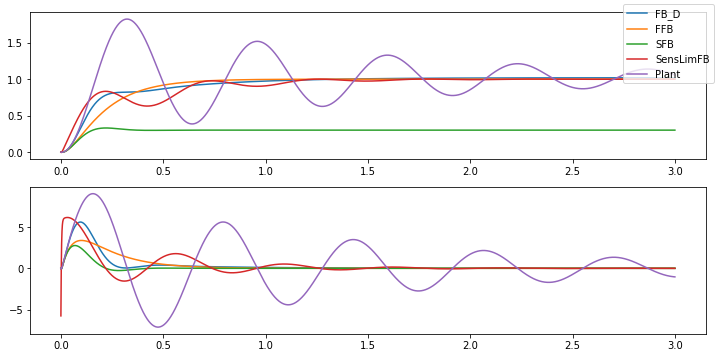

In [59]:
# 時間応答の比較
pyplot.clf()
fig,axes=pyplot.subplots(2,1)
pyplot.gcf().set_size_inches(10,5)

T=linspace(0,3,10000)

sres=step_response(fbsys_d,T)
ires=impulse_response(fbsys_d,T,)
axes[0].plot(sres.t,sres.y[0, 0,:],label="FB_D")
axes[1].plot(ires.t,ires.y[0, 0,:])

sres=step_response(FFB,T)
ires=impulse_response(FFB,T,)
axes[0].plot(sres.t,sres.y[0,0,:],label="FFB")
axes[1].plot(ires.t,ires.y[0,0,:])

sres=step_response(fbsys_e,T)
ires=impulse_response(fbsys_e,T,)
axes[0].plot(sres.t,sres.y[0,0,:],label="SFB")
axes[1].plot(ires.t,ires.y[0,0,:])
             
sres=step_response(LimSenFB,T)
ires=impulse_response(LimSenFB,T,)
axes[0].plot(sres.t,sres.y[0,0,:],label="SensLimFB")
axes[1].plot(ires.t,ires.y[0,0,:])

sres=step_response(SS,T)
ires=impulse_response(SS,T,)
axes[0].plot(sres.t,sres.y[0,0,:],label="Plant")
axes[1].plot(ires.t,ires.y[0,0,:])
fig.legend()
fig.tight_layout()

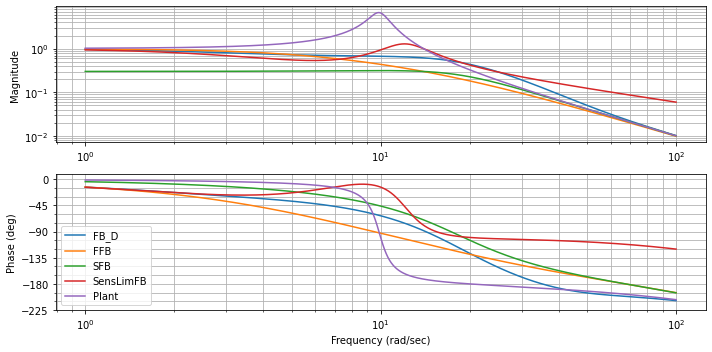

In [60]:
#omega=linspace(1.0,1e2,4000)
omega=numpy.logspace(0,2,4000)
bp=control.bode_plot(fbsys_d,omega,label="FB_D")
bp=control.bode_plot(ss([],[],[], [1,0])*FFB, bp[2],label="FFB")
bp=control.bode_plot(ss([],[],[], [1,0])*fbsys_e,bp[2],label="SFB")
bp=control.bode_plot(LimSenFB,bp[2],label="SensLimFB")
bp=control.bode_plot(SS,omega,label="Plant")
pyplot.gcf().set_size_inches(10,5)
pyplot.legend();pyplot.tight_layout()

`bode_plot()`,`nyquist_plot` は複数のシステムを一度に指定することも可能です。

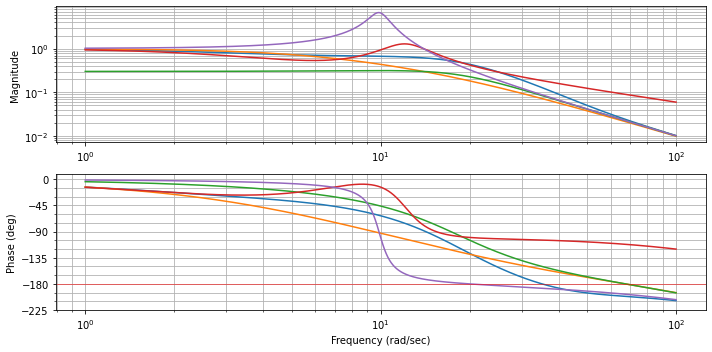

In [61]:
#omega=linspace(1.0,1e2,40000)
omega=numpy.logspace(0,2,4000)
pyplot.clf()
np=control.bode_plot([
  fbsys_d,
  ss([],[],[], [1,0])*FFB,
  ss([],[],[], [1,0])*fbsys_e,
  LimSenFB,
  SS
  ],
  omega,
)
pyplot.gca().axhline(-180,color="red", linewidth=0.5)
pyplot.gcf().set_size_inches(10,5)
pyplot.tight_layout()

### Python-controlで利用可能なその他のプロット

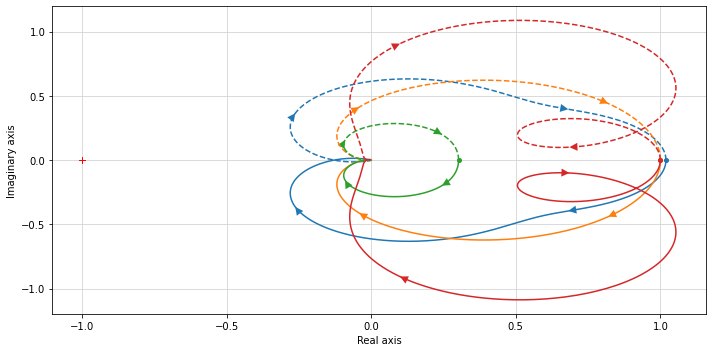

In [62]:
#omega=numpy.logspace(-3,2,4000)
np=control.nyquist_plot([fbsys_d,
                         ss([],[],[], [1,0])*FFB,
                         ss([],[],[], [1,0])*fbsys_e,
                         LimSenFB,
                        ],
                        #omega=omega,
                        omega_limits=(0.001,1e3), omega_num=4096, 
                        plot=True)
fig=pyplot.gcf()
fig.set_size_inches(10,5)
fig.tight_layout()

## マージン
SISOシステムでは`margin()`でゲインマージン(gm),位相マージン(pm), 位相が-180度を超える周波数(wcg), ゲインが1を下回る周波数(wcp)を求めます。

In [63]:
#    gm : float
#        Gain margin
#    pm : float
#        Phase margin (in degrees)
#    wcg : float or array_like
#        Crossover frequency associated with gain margin (phase crossover
#        frequency), where phase crosses below -180 degrees.
#    wcp : float or array_like
#        Crossover frequency associated with phase margin (gain crossover
#        frequency), where gain crosses below 1.

for s in [fbsys_d,
  ss([],[],[], [1,0])*FFB,
  ss([],[],[], [1,0])*fbsys_e,
  LimSenFB, Plant
  ]:
  print(f"name: {s.name},\n\t dcgain:{s.dcgain()}, \n\t poles:{s.poles()}\n\t margin:{control.margin(s)}")

name: fbsys_d,
	 dcgain:1.0193679918449612, 
	 poles:[-400.         +0.j         -400.33306731 +0.j
  -27.0760555 +22.7187251j   -27.0760555 -22.7187251j
  -10.81941689+14.62992761j  -10.81941689-14.62992761j
   -2.35384738 +0.j        ]
	 margin:(7.776876025647362, 171.63322451118484, 35.16135765238297, 0.6017375201380387)
name: sys[283],
	 dcgain:0.9999999999999366, 
	 poles:[-398.77529207 +0.j         -400.         +0.j
  -21.30522569+23.47099576j  -21.30522569-23.47099576j
   -5.92012251 +0.j          -16.94341919 +0.j        ]
	 margin:(46.81557959955664, inf, 67.3510554961839, nan)
name: sys[286],
	 dcgain:0.30202851696824606, 
	 poles:[-399.99999966 +0.j         -400.00000034 +0.j
  -10.81941689+14.62992761j  -10.81941689-14.62992761j
  -21.30522569+23.47099576j  -21.30522569-23.47099576j]
	 margin:(44.50463396423072, inf, 67.35105549618392, nan)
name: sys[107],
	 dcgain:1.0, 
	 poles:[-388.6087963  +0.j           -2.21733464+11.90386149j
   -2.21733464-11.90386149j   -2.7145344

## その他のシステム分析ツール
stability_margins/phase_crossover_frequencies/step_info/root_locus/pzmap/sisotool


In [64]:
"""
control.stability_margins(sysdata, returnall=False, epsw=0.0, method='best')
returs:

gm (float or array_like) – Gain margin

pm (float or array_like) – Phase margin

sm (float or array_like) – Stability margin, the minimum distance from the Nyquist plot to -1

wpc (float or array_like) – Phase crossover frequency (where phase crosses -180 degrees), which is associated with the gain margin.

wgc (float or array_like) – Gain crossover frequency (where gain crosses 1), which is associated with the phase margin.

wms (float or array_like) – Stability margin frequency (where Nyquist plot is closest to -1)
"""

control.stability_margins(fbsys_d)

(7.776876025647362,
 171.63322451118484,
 0.7508618018098547,
 35.16135765238297,
 0.6017375201380387,
 23.778178405049818)

In [65]:
control.phase_crossover_frequencies(fbsys_d)

(array([35.16135765,  0.        ]), array([-0.12858634,  1.01936799]))

In [66]:
control.step_info(fbsys_d)

{'RiseTime': 0.6011988851077203,
 'SettlingTime': 1.3450551327833744,
 'SettlingMin': 0.9181449566557959,
 'SettlingMax': 1.0193679918449612,
 'Overshoot': 0,
 'Undershoot': 0.015830902887751644,
 'Peak': 1.018890164692977,
 'PeakTime': 2.9346657442546347,
 'SteadyStateValue': 1.0193679918449612}

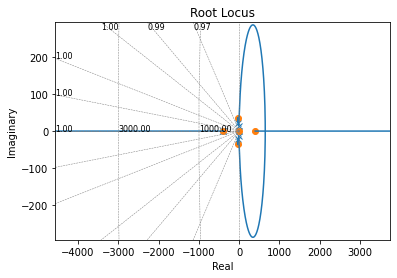

In [67]:
roots, gains=control.root_locus(fbsys_d)

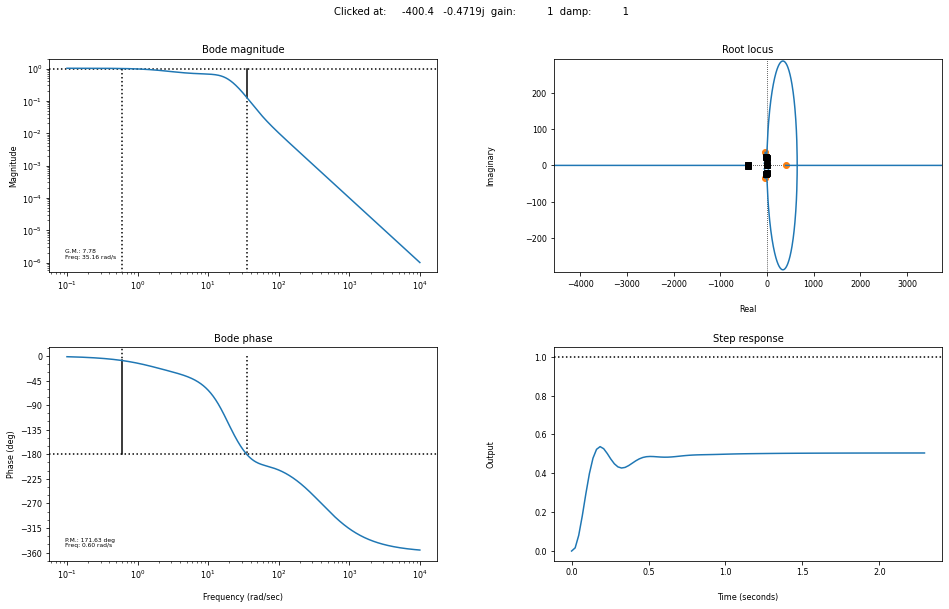

In [68]:
#control.sisotool : 名前の通り、sisoのLTIを引数にとって、典型的な図を作成します。
"""
Sisotool style collection of plots inspired by MATLAB’s sisotool. 
The left two plots contain the bode magnitude and phase diagrams. 
The top right plot is a clickable root locus plot, clicking on the root locus will change the gain of the system. 
The bottom right plot shows a closed loop time response.
"""
control.sisotool(fbsys_d)
pyplot.gcf().set_size_inches((16,9))

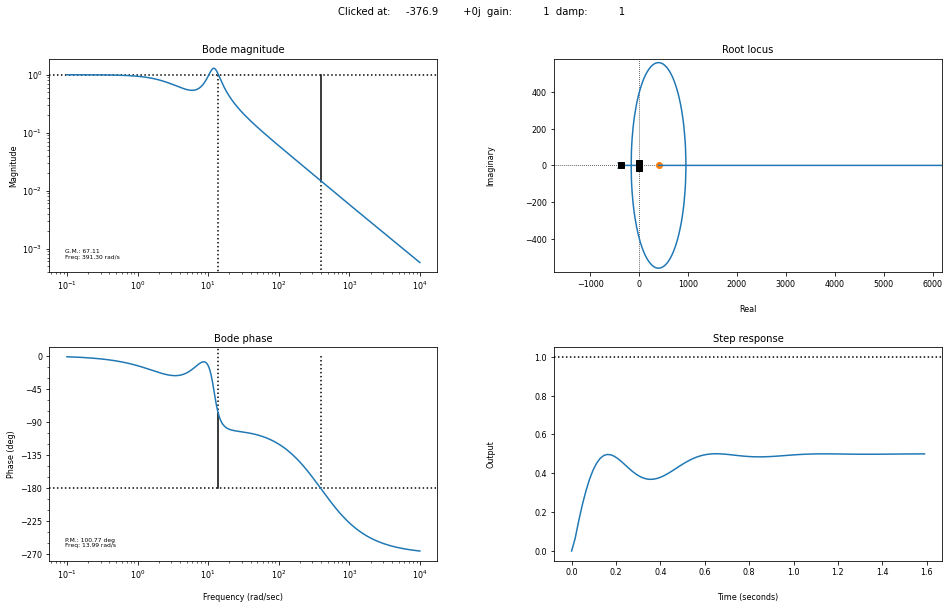

In [69]:
control.sisotool(LimSenFB)
pyplot.gcf().set_size_inches((16,9))

## ニコラス図


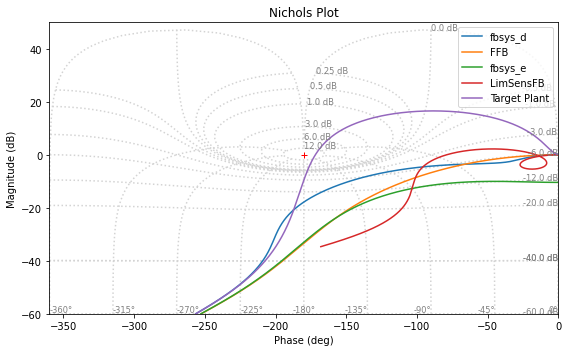

In [70]:
control.nichols_plot(
  (fbsys_d,
   ss([],[],[], [1,0])*FFB,
   ss([],[],[], [1,0])*fbsys_e,
   LimSenFB, 
   Plant
  ) ,numpy.logspace(-2,2.5,4096) #linspace(0.1,1e2,40000)
)
pyplot.gca().legend(["fbsys_d","FFB","fbsys_e","LimSensFB", "Target Plant"])
pyplot.gcf().set_size_inches(8,5)
pyplot.tight_layout()

### Gang of 4 plot
入力の二つのシステム $P$ , $C$　に対して、
```
 L = P * C
 S = feedback(1, L)
 T = L * S
```
で定義される$T,S$を使い、　$[T, PS; CS, S]$の四つの周波数応答をプロットしたもの

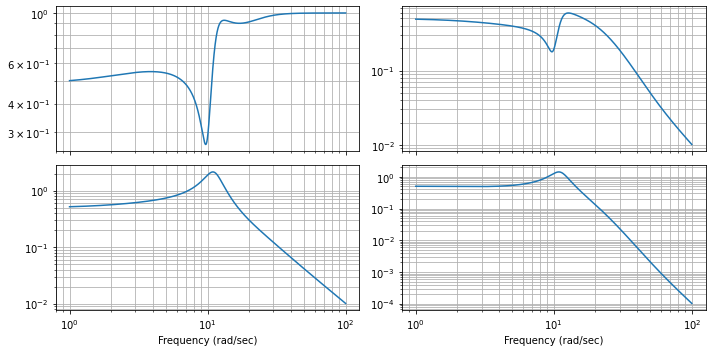

In [71]:
omega=numpy.logspace(0,2,4000)
control.gangof4_plot(fbsys_d,Plant, omega)
fig=pyplot.gcf()
pyplot.gcf().set_size_inches(10,5)
#fig.legend()
fig.tight_layout()

### singular values plot

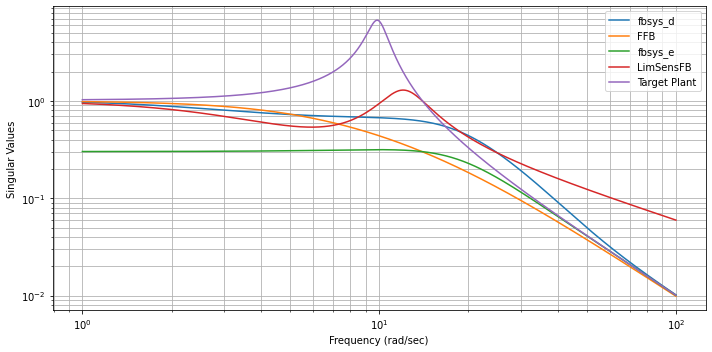

In [72]:
control.singular_values_plot([fbsys_d,
                                ss([],[],[], [1,0])*FFB,
                                ss([],[],[], [1,0])*fbsys_e,
                                LimSenFB, Plant
                               ]
                               ,omega)
fig=pyplot.gcf()
fig.set_size_inches(10,5); fig.tight_layout()
pyplot.gca().legend(["fbsys_d","FFB","fbsys_e","LimSensFB", "Target Plant"])

## タイムドメインでの応答を調べるための関数の使用例
python/controlモジュールの機能を使って、タイムドメインでのシステムの振る舞いを見てみます。

`control.forced_response()`は与えられた入力の時間変化データに対するシステムの応答を計算します。
計算結果は、`inputs, outputs, states` の属性を持つオブジェクトとして返されます。

<Figure size 432x288 with 0 Axes>

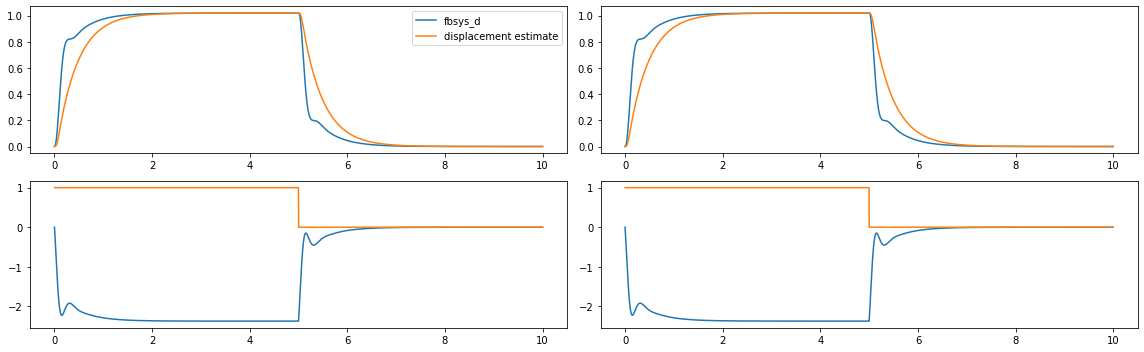

In [73]:
# control.forced_response 関数を使って、矩形入力に対する応答を見てみる。
# control.matlab.lsimも同様の機能をもつ。
Nd=4096;Tw=10; Tsw=5
T=numpy.linspace(0,Tw,Nd)
U=numpy.zeros(Nd)
U[0:Nd//(Tw//Tsw)]=1

pyplot.clf()
fig,axes=pyplot.subplots(2,2, figsize=(8,5))
fig.set_size_inches(16,5)

# forced_response/control.matlab.lsim 関数
result=control.forced_response(fbsys_d,T=T,U=U)
axes[0,0].plot(result.time,result.outputs, label="fbsys_d")
axes[0,0].plot(result.time,result.states[-1,:], label="displacement estimate")
ufb=numpy.array( -K@(result.states[0:3,:]))[0,:]
axes[1,0].plot(result.time, ufb, label="ufb")
axes[1,0].plot(result.time,result.inputs, label="input")

# control.input_output_response 関数
# 第一引数は　SSとは別のクラスオブジェクトが必要。
result=control.input_output_response(control.ss2io(fbsys_d), T=T, U=U)

axes[0,1].plot(result.time, result.outputs, label="fbsys_d")
axes[0,1].plot(result.time, result.states[-1,:], label="displacement estimate")
ufb=numpy.array(-K@(result.states[0:3,:]))[0,:]
axes[1,1].plot(result.time, ufb, label="ufb")
axes[1,1].plot(result.time, result.inputs, label="input")
pyplot.tight_layout()
pyplot.gcf().axes[0].legend()
#axes[0,0].legend();axes[0,1].legend()

In [74]:
# margin関数は、システムの以下の情報を表示します。
# gm : float
#        Gain margin
#    pm : float
#        Phase margin (in degrees)
#    wcg : float or array_like
#        Crossover frequency associated with gain margin (phase crossover
#        frequency), where phase crosses below -180 degrees.
#    wcp : float or array_like
#        Crossover frequency associated with phase margin (gain crossover
#        frequency), where gain crosses below 1.
print(control.margin(fbsys_d),control.margin(Plant))

(7.776876025647362, 171.63322451118484, 35.16135765238297, 0.6017375201380387) (3.0074504054896884, 8.11056518752136, 19.933764307100347, 13.995414100411594)


# 付録
## 等価な状態空間を用いた解析

状態方程式によるシステムの表現は一意的ではなく、同じ入力と出力の関係を保ちながら、異なった状態空間に写すことができます。 `canonical_form`関数をつかうことで、"reachable, observable, modal”と言った
標準形に変換したら、min_real()　関数／メソッドを使うことで、内部状態の数が最小となる等価な状態空間表現に変換できます。



等価な二つの状態空間の状態ベクトル $X$ と $X'$ がお互いに正則な行列 $U$ で関連付けれれているとき、$ X= U^{-1} X',　X' = U X$状態方程式の係数も
$ A' = U A U^{-1}, B' = U B, C' = C U^{-1} , D' = D$ と変換されれば、この二つの状態空間表示 $ ss(A,B,C,D)$ と ss(A',B',C',D')$ は 等価な状態空間表示で、入力と出力の関係が一致します。


二つの状態空間の状態変数が $X' = U X$ の関係を持つ時、状態方程式の係数が $A = U A' U^{-1}, B= U B', C= C' U^{-1}, D= D'$ と変換されれば、等価な状態方程式を与える。Ricatti 方程式の解　は$P' = U^T P U$ を持つ。フィードバックゲインは、

$$K'= - R^{-1} B'^{T} P' = - R^{-1} B^{T} {U^{T}}^{-1} U^{T} P U= -K U$$

となる。この時、最適状態制御の制御則は、$ u = -K' X' = - K X$を与える　$K$ および　$K$は　$K = K' U^{-1}$で関係付けられる。
この時、最適化されている量は、
$\int dt \left[ X^{T} Q X + u^{T} R u \right]= \int dt \left[ {X'}^{T} U^{T} Q U X' + u^{T} R u \right]
となり、$X'$空間で見た時の、状態変数に対する重み関数 $Q'$は　$Q$とは異なり対称ではあるが、対角な行列とは限らない。このため、単純に対角な重み関数を選んでも、元の状態空間での結果を再現することはできない。

最適化の条件を$\int dt \left[ X^{T} Q X + u^{T} R u \right]$ではなく、物理的な入出力に限って
$\int dt \left[ Y^{T} Q Y + u^{T} R u \right]$を極小とすることで、状態空間の選択によらないフィードバックを得る。

$$
A^T P + P A - P B R^{-1} B^T P + Q = 0
$$

$$
 A' U^T P U + U^{T}P U A'   - U^{T}P U B' R^{-1} B'^{T}  U^{T}  P U + U^{T} Q U= 0
$$


別の方法として、 `lqr` の  `Q` を  可観測行列を使って、$obsv^{T} Q_o obsv$ とパラメータ化しておくと、状態空間によらない
重み付け行列 $O_o$ を使うことができます。　`lqe`では `G` を `obsv G_o` として、パラメータ化することで、状態空間の選択に依存しない重み行列 $G_o$ を使うことができます。

In [75]:
"""
form : str
        Canonical form for transformation.  Chosen from:
          * 'reachable' - reachable canonical form
          * 'observable' - observable canonical form
          * 'modal' - modal canonical form
"""
PhyM=control.canonical_form(Delay*phym,"reachable")[0].minreal()

print(control.obsv(PhyM.A,PhyM.C))
print(control.ctrb(PhyM.A,PhyM.B))
print(matmul(control.obsv(PhyM.A,PhyM.C).transpose(),Qo)*control.obsv(PhyM.A,PhyM.C))

[[ 0.00000000e+00  0.00000000e+00  4.12310563e+02]
 [ 0.00000000e+00 -4.00734620e+04 -9.70142500e+03]
 [ 7.78071317e+06  1.92527766e+06  2.11369797e+04]]
[[ 9.68364052e-03 -3.64589066e+00  1.46311722e+03]
 [ 2.49541704e-03 -1.94136107e+00  7.54228139e+02]
 [ 0.00000000e+00 -2.42535625e-01  1.94392303e+02]]
[[ 0.00000000e+00  0.00000000e+00  3.20807022e+09]
 [ 0.00000000e+00  1.60588235e+09 -1.86779369e+10]
 [ 3.20807022e+09 -1.86779369e+10  4.46771912e+08]]


In [76]:
# 状態フィードバックゲイン
PhyM=control.canonical_form(Delay*phym,"modal")[0].minreal()
PhyM=PhyM.minreal()
#Qw=2e3
# Qとして、matmul(SS.C.transpose(),SS.C)を使ってみる、これは $\int dt y^{T} y $を最小化するのと等価。
#
Qw=10
Qo=diag([1,0,0])
Q=matmul(control.obsv(PhyM.A,PhyM.C).transpose(),matmul(Qo, control.obsv(PhyM.A,PhyM.C)))
K,P,e_K=control.lqr(PhyM.A, PhyM.B, Q ,diag([1/Qw]))

K=matrix(K) # あるいは、行列としての積がが必要なところで、numpy.matmulを使う。

#推定器ゲイン
Gw=10
G=matmul(control.ctrb(PhyM.A, PhyM.B),diag([1, 0, 0]))
H,P,e_H=control.lqe(PhyM.A, 
                 Gw*G,
                 PhyM.C, 
                 diag([1, 1, 1]),
                diag([1]))
H=matrix(H) # あとで、行列としての演算が必要なのでarrayではなく、matrixにしておく。

# ObsvはPlantからの出力　:math:`y` を入力として、フィードバック用の出力　:math:`u`を出力する。
# この推定器だと、元のシステムで入力が0の場合の動作しか推定していない。
Obsv=control.ss(
  PhyM.A - numpy.matmul(H,PhyM.C) - numpy.matmul(PhyM.B, K),
  H,
  -K , 
  numpy.matrix([0])
)
Obsv.name="Observer"
Obsv

<LinearIOSystem:Observer:['u[0]']->['y[0]']>

dcgain: 0.661208626104003


<Figure size 432x288 with 0 Axes>

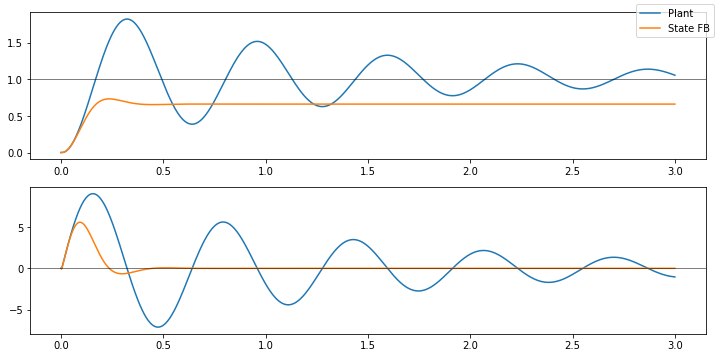

In [77]:
fbsys=PhyM.feedback(Obsv,1) 
print("dcgain:",fbsys.dcgain())

T=linspace(0,3,1000)
pyplot.clf()
fig,axes=pyplot.subplots(2,1)
fig.set_size_inches(10,5)

#r0=-0.0001/4
r0=0.1
sres=step_response(SS,T)
ires=impulse_response(SS,T)
axes[0].plot(sres.t,sres.y[0,0,:],label="Plant")
axes[1].plot(ires.t,ires.y[0,0,:])

sres=step_response(fbsys,T)
ires=impulse_response(fbsys,T)
axes[0].plot(sres.t,sres.y[0,0,:], label="State FB")
axes[1].plot(ires.t,ires.y[0,0,:])
axes[0].axhline(1,color="black",linewidth=0.5)
axes[1].axhline(0,color="black",linewidth=0.5)
fig.legend();fig.tight_layout()

## 外乱オブザーバを入れた時に期待されるDCgainの説明

$\frac{d \delta}{dt} = 0$ から、
$C \left(\hat{x} - x \right) = \delta$
となります。。
これを 
$\frac{d \hat{x}}{d t} = 0$
に代入すると、
$0= \left(A - B K\right)\hat{x}$
となりますが、
$K$
の選択によって、
$A- B K$
は正則です。
従って、
$\hat{X} = 0$
かつ
$\frac{d X} {d t}=0$
の条件は、結局、
$A X + B r = 0$
に帰着されます。
$A$
が正則の場合には、
$$
y= -C A^{-1} B r
$$
となります。

一般には、$A$は正則とは限りませんが、その場合は$\det{A} = 0$となります。これは、システムは$s=0$に極をもち、入力の積分を含むことを意味しています。
この場合、入力が $r=0$ でなければ状態変数が発散してしまいます。ということで、DC Gainが意味を持つためには $A$ が正則である場合のみととも言えます。


これを例題のシステムについて計算すると、

In [78]:
- (SS.C@matrix(SS.A)**(-1))@SS.B

matrix([[1.01936799]])

とDCgainは 被制御対象システムのDCgainと同じであることが確認できました。

# 伝達関数から状態方程式への変換について

伝達関数の考え方は、入力 $u$ と出力 $y$ の関係は、微分方程式::

$$
\begin{cases}
y^{(N)} &= - \Sigma_{k=0}^{N-1} a_k y^{(k)} + \Sigma_{k=0}^{M} b_k u^{(k)} \\
y^{(k)} &\equiv \frac{d^k y}{d t^k}\quad\text{for}\; k \ge 1,\\ 
y^{(0)} &\equiv y\\
\end{cases}
$$

によって記述されるということです。ラプラス変換を行うと、

$$
Y(s) = \frac{\Sigma_{k=0}^{M} b_k s^k}{\Sigma_{k=0}^{N} a_k s^k} U(s) 
$$

となります ( $a_N \equiv 1$ とします)。

この微分方程式を状態変数
$X=\begin{pmatrix} x_0\\x_1\\ \vdots \\ x_n \end{pmatrix}$
の状態方程式に書き換えることができれば、システムを伝達関数の記述から、状態方程式に書き換えることができたということになります。
よく知られたように、システムがプロパー、すなわち 条件：　
$N \ge M$
が成り立つ、であればこれは可能です。

実際、この場合には、等価な状態方程式は、

$$
\frac{d \vec{X}}{d t} =  A \vec{X} +  B {u} \\
{y} = {C} \vec{X} + {D} {u}
$$

となります。(入力 $u$ および　出力$y$はスカラーであることに注意）
状態　
$X$
は、
$$
\vec{X} =\begin{pmatrix} x \\ x^{(1)}\\ x^{(2)}\\\vdots\\x^{(N-1)}\end{pmatrix}
$$
となっています。

ここで、
$A,B,C,D$
を　
$$
{A} = \begin{pmatrix} 0,& 1,& 0,& 0,& \cdots&, 0\\
   0,& 0,& 1,& 0,& \cdots &, 0\\
   \vdots& \vdots& \vdots& \vdots& \ddots& \vdots\\
   0,& 0,& 0,& 0,& \cdots&, 1\\
   -a_0,& -a_1,& -a_2,& -a_3,& \cdots&, -a_{N-1} \\
   \end{pmatrix}\\
   \\
{B} = \begin{pmatrix} 0\\ 0\\  \vdots \\ 0\\ 1\end{pmatrix} \\
{C} = \begin{pmatrix} b_0 - b_N a_0,& b_1 - b_N a_1,& \cdots, b_{N-1}-b_N a_{N-1}\end{pmatrix}\\
   \\
{D} = b_N \\
$$
で定義します。　ここで、
$b_k= 0 \text{ for } N \le k \gt M$
としています。

状態方程式の第一式は、

$$
 x^{(n)} = -\Sigma_{k=0}^{N-1} a_k x^{(k)} + u
$$

に帰着されます。　$a_N=1$とすれば、

$$
 \Sigma_{k=0}^{N} a_k x^{(k)} = u
$$

となります。

$$
   y = \Sigma_{k=0}^{N-1}\left(b_k-b_N a_k\right)\frac{d^k x}{d t^k} + b_N u
$$

となる。両辺から 
$\Sigma_{k=0}^{N} a_k \frac{d^k}{d t^k}$
を掛けて

$$
   \Sigma_{k=0}^{N} a_k \frac{d^k y}{d t^k} = \Sigma_{k=0}^{N-1}\left(b_k-b_N a_k\right)\frac{d^k u}{d t^k} + b_N \Sigma_{k=0}^{N} a_k \frac{d^k u}{d t^k}\\
   = \Sigma_{k=0}^{N-1}b_k\frac{d^k u}{d t^k} + b_N \frac{d^N u}{d t^N}\\
   = \Sigma_{k=0}^{N}b_k\frac{d^k u}{d t^k}\\
$$

となります( 
$a_N = 1$
に注意)。 このように、
$N \ge M$
であれば、伝達関数表示と状態方程式表示が等価であることが明示的に示されます。

### 可制御標準型
この伝達関数表示から作成した、状態変数表示は可制御標準型と呼ばれます。可制御性を調べるために、$B, A B, A^2B, \dots A^{N-1}B$を考えると、

$$
\begin{pmatrix} 0\\ 0\\  \vdots \\ 0\\ 1\end{pmatrix}, \begin{pmatrix} 0\\ 0\\  \vdots \\ 0 \\ 1\\ -a_{N-1}\end{pmatrix},
\begin{pmatrix} 0\\ 0\\  \vdots  \\ 1\\ -a_{N-1}\\- a_{N-2}-a_{N-1}^2\end{pmatrix},\dots 
\begin{pmatrix} 1\\ a_{N-1}\\- a_{N-2}-a_{N-1}^2 \\ \vdots \\\vdots \\ \end{pmatrix}
$$

となって、この状態変数表示のシステムは可観測であることが自明となる。

## 伝達関数が既約でない時？
$$
\Sigma_{k=0}^{N+1} a'_k s^k = (s-\lambda) \left(\Sigma_{k=0}^{N} a_k s^k\right) = \Sigma_{k=0}^{N}\left(a_k s^{k+1} - \lambda a_k s^k\right)
$$
より、
$$\begin{cases}
a'_0= -\lambda a_0, \\
a'_k=a_{k-1}-\lambda a_{k} \quad\left( 1\le k \le N\right), \\
a'_{N+1} = a_{N}\\
\end{cases}
$$
$$
{C'} = \begin{pmatrix} b'_0 - b'_{N+1} a'_0,&
b'_1 - b'_{N+1} a'_1,&
\cdots, &
b'_{N}-b'_{N+1} a'_{N}\end{pmatrix}\\
$$
$$
{C'} = \begin{pmatrix} \lambda b_0 + b_N \lambda a_0 ,&
  b_0 -\lambda b_1 - b_{N} (a_0 - \lambda a_1),& \cdots, b_{N-1}-\lambda b_{N} - b_{N}(a_{N-1} - \lambda a_{N})\end{pmatrix}\\
$$
$$
{A'} = \begin{pmatrix} 0,& 1,& 0,& 0,& \cdots&, 0\\
   0,& 0,& 1,& 0,& \cdots &, 0\\
   \vdots& \vdots& \vdots& \vdots& \ddots& \vdots\\
   0,& 0,& 0,& 0,& \cdots&, 1\\
   \lambda a_0,& -a_0 + \lambda a_1,& -a_1 +\lambda a_2,& , -a_2+\lambda a_3,& \cdots &, -a_{N-1}+\lambda a_N\\
   \end{pmatrix}\\
$$
$$
{B'} = \begin{pmatrix} 0\\ 0\\  \vdots \\ 0\\ 1\end{pmatrix} \\
$$
$$
B',A'*B', ...
$$
を考えると
$$
\begin{bmatrix}0\\0\\0\\\vdots\\1\end{bmatrix},
\begin{bmatrix}0\\0\\\vdots\\1\\-a_{N-1}+\lambda a_N\end{bmatrix}
\begin{bmatrix}0\\\vdots\\1\\-a_{N-1}+\lambda a_N\\ -a_{N-2}+\lambda a_{N-1}+(-a_{N-1}+\lambda a_N)\end{bmatrix}
$$

## なぜプロパーでない伝達関数は状態方程式にかきかえられないのか？

今見たように、プロパーなシステムでは、一次の微分方程式である状態方程式にかきかえられますので、ある時点での状態と入力値から次の状態を微分方程式から決定できます。インプロパーなシステムでは、階数がNより大きい入力の微分$u^{(m)}$が必要となります。
これを、"将来の入力値”が必要となると表現されますが、これについて少し考察してみます。

伝達関数のラプラス変換を出力$Y(s)$について解いた式：
$$
Y(s) = \frac{\Sigma_{k=0}^{M} b_k s^k}{\Sigma_{k=0}^{N} a_k s^k} U(s)
$$
の分母を因数分解をおこない、部分分数展開すれば、

$$
Y(s) = \left( \Sigma_{k=0}^{M-N} \alpha_k s^k + \Sigma_{k=0}^{N}\frac{\beta_k}{s-\lambda_k} \right)U(s)
$$
となる。これのラプラス逆変換を行えば、

$$
y(t) =  \Sigma_{k=0}^{M-N} \alpha_k \frac{d^k u(t)}{dt^k} + \Sigma_{k=0}^{N} \beta_k \int_{-\infty}^{0}d\tau e^{-\lambda_k \tau}u(t+\tau)
$$

$ M \gt N $の場合には、この式の右辺は、入力の微分項を含むことになる。
このことから、プロパーでない伝達関数は微分を含むということになる。

プロパーでない系では、上記の形式解の右辺に現れる微分$s$を不完全微分$\frac{s}{1+T_D s}$などで置き換えるのが普通のやり方だそうです。

$$
\frac{d y}{d t} = a_0 y + b_0 u +b_1 u' + b_2 u''
$$


## 不完全微分 $\frac{s}{1+T_D s}$ と単純な微分回路

抵抗　$R$ と　コンデンサ $C$ で構成される微分回路のインピーダンスは $\frac{R}{R+ \frac{1}{j C \omega}}$ です。これをラプラス変換に書き直せば $\frac{R C s}{1+R C s}$ と不完全微分の形になります。

## 伝達関数と状態表示の関係。

上で見たように、プロパーな伝達関数:

$$
Y(s) = \frac{b_M s^M +b_{M-1}s^{M-1} \dots b_1 s + b_0}{s^N+a_{N-1} s^{N-1} + \dots + a_1 s +a_0} U(s)
$$

は、状態方程式表示:

$$
\left\lbrace\begin{aligned}
\frac{d X}{d t} = A x + B u \\
Y = C X + D u\\
\end{aligned}\right.
$$

に変換することが可能です。逆に、状態変数表示からは、

$$
Y(s) = \left[C\left(s I - A\right)^{-1} B +D\right] U(s)
$$

によって、伝達関数表示に移ることが可能です。この時、複数の状態変数が同じ伝達関数が実現されます。
特に、 1入力1出力のシステムであれば、　$Y^T=Y, U^T=U, D^T = D$ ですから、
$$
\begin{aligned}
Y(s) &= \left[C\left(s I - A\right)^{-1} B +D\right] U(s) \\
&=  \left[B^T\left(s I - A^T\right)^{-1} C^T +D\right] U(s)
\end{aligned}
$$

が成り立ちます。これは、もとの伝達関数のシステムは、

$$
\left\lbrace\begin{aligned}
\frac{d \hat{X}}{d t} = A^T \hat{X} + C^T u \\
Y = B^T \hat{X} + D u\\
\end{aligned}\right.
$$
と等価です。プロパーな伝達関数から構成される状態変数表示では、$A, B$ は可制御でした。これから転置行列を使った状態変数表示のシステムは、
$A^T, B^T$ から構成される可観測行列のランクが状態変数の次元に一致することから、可観測ということになります。
結局、プロパーな伝達関数を持つシステムは、状態変数表示に移ると、可制御かつ可観測なシステムで表現されることがわかります。

.. note::

   双対な制御システムは通常、信号の向きを逆転したシステムとして認識される。可制御性と可観測性が入れ替わるシステムとも言える。
   
   

$$
{A_o} = \begin{pmatrix} 0,& 0,& 0,& \cdots&,0,&  -a_0\\
   1,& 0,& 0,& \cdots &, 0,& -a_1\\
   0,& 1,& 0,& \cdots &, 0,&-a_2\\
   \vdots& \vdots& \vdots& \ddots& \vdots& \vdots\\
   0,& 0,& 0,& \cdots&,0,&  a_{N-2}\\
   0,& 0,& 0,& \cdots&, 1,& -a_{N-1} \\
   \end{pmatrix}\\
   \\
{B_o} = \begin{pmatrix} b_0 - b_N a_0,\\ b_1 - b_N a_1,\\ \vdots \\ b_{N-1}-b_N a_{N-1}\end{pmatrix}\\
{C_o} = \begin{pmatrix} 0, 0,  \cdots , 0, 1\end{pmatrix} \\
   \\
{D_o} = b_N \\
$$
$$
s*x_0= -a_0 x _{N-1}+ (b_0-b_N a_0) u\\
s*x_1 = x_0 - a_1 x_{N-1} + (b_1 -b_N a_1) u\\
\vdots\\
s*x_{N-1}= x_{N-2} - a_{N-1} x_{N-1} + (b_{N-1} - b_N a_{N-1}) u\\
$$

$$
\begin{aligned}
s*x_0 &= -a_0 x_{N-1}+ (b_0-b_N a_0) u\\
s^2*x_1 &= s*x_0 - s*a_1 x_{N-1} + s*(b_1 -b_N a_1) u \\
&= -a_0 x_{N-1} - a_1 s x_{N-1} + (b_0-b_N a_0) u  + (b_1 -b_N a_1)s u\\
&\vdots\\
s^{N-1} x_{N-2} &= s^{N-2} x_{N-3} - a_{N-2} s^{N-2} x_{N-1} + (b_{N-2} - b_N a_{N-2})s^{N-2} u\\
&= s^{N-3} x_{N-4} - a_{N-3} s^{N-3} x_{N-1} +(b_{N-3} - b_N a_{N-3}) s^{N-3} u  - a_{N-2} s^{N-2} x_{N-1}
+ (b_{N-2} - b_N a_{N-2})s^{N-2} u\\
s^{N}*x_{N-1}&= s^{N-1}x_{N-2} - a_{N-1} s^{N-1} x_{N-1} + (b_{N-1} - b_N a_{N-1}) s^{N-1} u\\
&= \Sigma_{k=0}^{N-1} \left( - a_k s^k x_{N-1}  + (b_k-b_N a_k) s^k u\right)
\end{aligned}
$$

これより、
$$
\Sigma_{k=0}^{N}a_k s^k x_{N-1} =  \Sigma_{k=0}^{N-1} (b_k-b_N a_k) s^k u
$$

$y= x_{N-1}  + b_N u$にこれを代入すると、

$$
\begin{aligned}
\Sigma_{k=0}^{N}a_k s^k y &= \Sigma_{k=0}^{N-1} (b_k-b_N a_k) s^k u + \Sigma_{k=0}^{N}a_k b_N s^k  u\\
&= \Sigma_{k=0}^{N-1} b_k s^k u+ a_N b_N s^N u =  \Sigma_{k=0}^{N} b_k s^k u\\
\end{aligned}
$$ 
ここで $a_N \equiv 1$ を使ったことに注意しておきます。

# 外乱オブザーバー
測定値 $Y$ に定値の外乱 $d$ がある時、状態を拡大して、

$$
X_e=\begin{bmatrix} X \\ d \\\end{bmatrix}
$$
を考えると、状態方程式は、

$$
\left\lbrace\begin{aligned}
\frac{d X_e}{d t} &=\begin{bmatrix} A,& 0\\ 0,& 0 \\\end{bmatrix} X_e 
+ \begin{bmatrix} B \\ 0 \end{bmatrix} \begin{bmatrix} u\\ 0 \end{bmatrix}\\
Y &= \begin{bmatrix} C,& 1 \end{bmatrix} X_e + D u \\
\end{aligned}\right.
$$

このとき、拡張された系 $A_e,B_e, C_e D_e$ は可観測だが、不可制御になってしまいます。それは単に外乱 $d$は推定可能だが、制御不能であることを言っているに過ぎなません。

可安定性:
   可制御ではなくても、制御不能なモードが安定であれば、システム全体を安定化させることはできる。このようなシステムを**可安定**なシステムとよびます。(「制御理論の基礎」page. 187)
   


In [79]:
#pip install -U graphviz
#https://h1ros.github.io/posts/introduction-to-graphviz-in-jupyter-notebook/
import graphviz

In [80]:
n = graphviz.Digraph(name='splines', engine='neato',
                     graph_attr={'splines': 'true'},
                     node_attr={'shape': 'point'})
n.node('a', pos='0,0!', color='blue')
n.node('b', pos='100,0!', color='green')
n.node('c', pos='50,50!', color='red')
n.edge('a', 'b', pos='0,0 30,66 70,60 100,0')
n.render(neato_no_op=2, directory='doctest-output').replace('\\', '/')

'doctest-output/splines.gv.pdf'

# モデルマッチングによるゲインチューニング(Pythonによる制御工学入門)

「Pythonによる制御工学入門」のモデルマッチングによるゲインチューニングの結果だけを確認してみましょう。


In [81]:
# model: Python による制御工学入門」　リスト 5.1 144ページ
g=9.81
l=0.2
M=0.5
Mgl=M*g*l
mu=1.5e-2
J=1.0e-2
ref=30 

num_delay,den_delay=control.pade(0.005,1)
Plant5=tf([1],[J, mu, Mgl])
Plant5d=tf([1],[J, mu, Mgl])*tf(num_delay,den_delay)
print(Plant5)
print(Plant5.poles(),Plant5.zeros(),Plant5.dcgain())


            1
--------------------------
0.01 s^2 + 0.015 s + 0.981

[-0.75+9.87610753j -0.75-9.87610753j] [] 1.019367991845056


In [82]:
#リスト　5.15　page. 169-170
omega_n=15
zeta=0.707
Msys=tf([0,omega_n**2],[1,2*zeta*omega_n,omega_n**2]) #規範モデル
#
kp=omega_n**2*J
ki=omega_n*M*g*l/(2*zeta)
kd=2*zeta*omega_n*J+M*g*l/(2*zeta*omega_n)-mu
#PI-D制御
Kpi=tf([kp,ki],[1,0]) #　　D制御
Kd=tf([kd,0],[1]) # PI制御
# PI-D制御
Gyr=control.feedback(Plant5.feedback(Kd)*Kpi,1)
#無駄時間を考慮したモデルの場合。係数はsympyによる結果を使った
kp_d,ki_d, kd_d=2.26963406250000, 10.4066478076379, 0.240297605658946
Kpi_d=tf([kp_d,ki_d],[1,0]) #　　D制御
Kd_d=tf([kd_d,0],[1]) # PI制御
Gyr_d=control.feedback(Plant5d.feedback(Kd)*Kpi,1)

<Figure size 432x288 with 0 Axes>

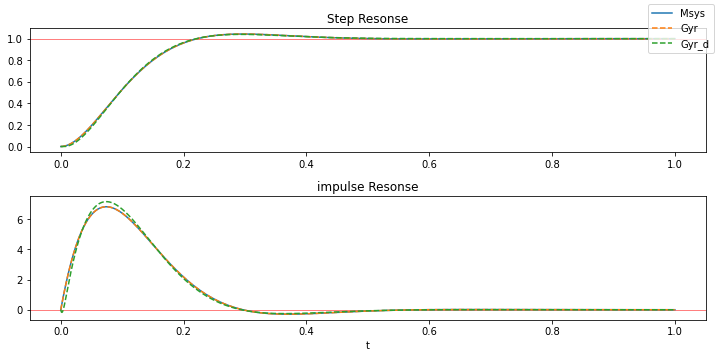

In [83]:
#ステップ応答とインパルス応答を図示します。
pyplot.clf()
fig,axes=pyplot.subplots(2,1)
fig.set_size_inches(10,5)
axes[0].set_title("Step Resonse");axes[1].set_title("impulse Resonse");
axes[1].set_xlabel("t");
axes[0].axhline(1.0,color="red",linewidth=0.5)
axes[1].axhline(0.0,color="red",linewidth=0.5)

T=linspace(0,1,4096)

sres=step_response(Msys,T)
ires=impulse_response(Msys,T,)
axes[0].plot(sres.t,sres.y[0, 0,:],label="Msys")
axes[1].plot(ires.t,ires.y[0, 0,:])

sres=step_response(Gyr,T)
ires=impulse_response(Gyr,T,)
axes[0].plot(sres.t,sres.y[0,0,:],label="Gyr",ls="--")
axes[1].plot(ires.t,ires.y[0,0,:],ls="--")

sres=step_response(Gyr_d,T)
ires=impulse_response(Gyr_d,T,)
axes[0].plot(sres.t,sres.y[0,0,:],label="Gyr_d",ls="--")
axes[1].plot(ires.t,ires.y[0,0,:],ls="--")

fig.legend()
fig.tight_layout()

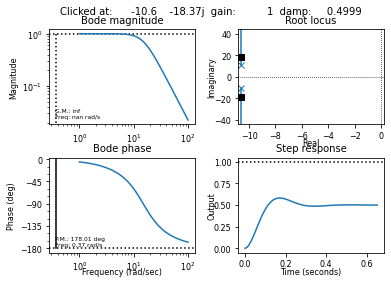

In [84]:
control.sisotool(Msys)

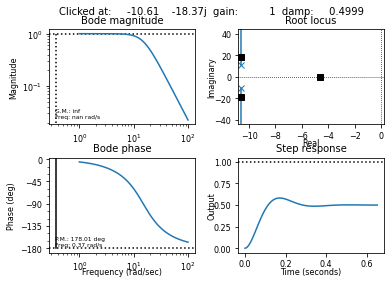

In [85]:
control.sisotool(Gyr)

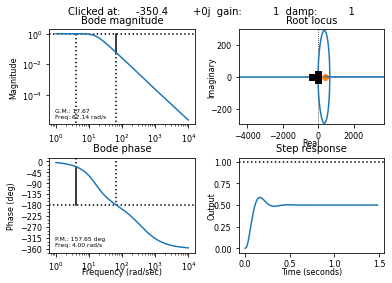

In [86]:
control.sisotool(Gyr_d)

### Sympy/contorl 

sympy.physics.controlにはLTIを取り扱うための関数がいくつか定義されています。
状態空間表示を直接的にサポートはしていませんが、`TransferFunctionMatrix`を使って、MIMOシステムを解析することができます。`TransferFunctionMatrix`は $C\left(s - A\right)^{-1}B$ の行列表示ということですね。


In [87]:
import sympy, sympy.physics.control as symcontrol
import sympy.physics.control.lti as lti
from sympy import var
sympy.init_printing(use_unicode=True,use_latex =True)

In [88]:
#　代数計算をおこなうシンボルを定義します。
var('s omega_s zeta_s kp_s ki_s kd_s')
var("J_s g_s l_s  mu_s M_s Mgl_s")

In [89]:
Msys_s=lti.TransferFunction(omega_s**2, s**2 + 2*zeta_s*omega_s*s + omega_s**2,s) #規範モデル
Plant_s=lti.TransferFunction(1, J_s*s**2 + mu_s*s + Mgl_s, s) # 物理モデル
Plantd_s=(lti.TransferFunction(1-s/400, 1+s/400,s)*Plant_s).doit() # 無駄時間を考慮したモデル。
# lti.TransferFunctionの積のオブジェクト型は、lti.TransferFunction　になりません。
# 積を.doit() あるいは .simplify()することで、結果のオブジェクト型がlti.TransferFunctionになります。

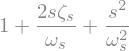

In [90]:
(1/Msys_s.to_expr()).simplify()

In [91]:
(1/Plant_s.to_expr())

In [92]:
Kpi_s=lti.TransferFunction(kp_s*s+ki_s, s, s ) #　　D制御
Kd_s=lti.TransferFunction(kd_s*s, 1, s) # PI制御
# PI-D制御
Gyr_s=lti.Feedback((lti.Feedback(Plant_s,Kd_s).doit()*Kpi_s).simplify(),
                 lti.TransferFunction(1,1,s)
                ).doit().simplify()
Gyr_ds=lti.Feedback((lti.Feedback(Plantd_s,Kd_s).doit()*Kpi_s).simplify(),
                 lti.TransferFunction(1,1,s)
                ).doit().simplify()

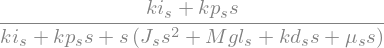

In [93]:
Gyr_s

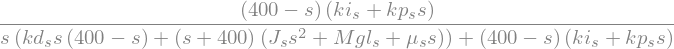

In [94]:
Gyr_ds

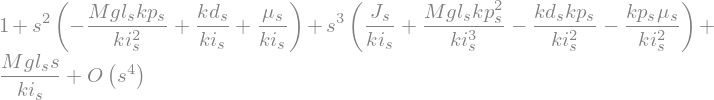

In [95]:
(1/Gyr_s.to_expr()).series(s,0,4)

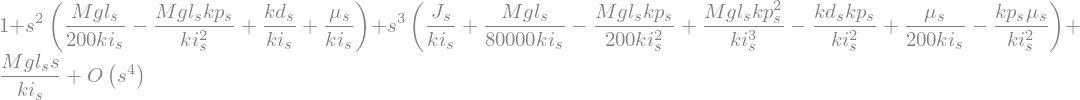

In [96]:
(1/Gyr_ds.to_expr()).series(s,0,4)

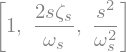

In [97]:
Msys_terms=[t for t in (1/Msys_s.to_expr()).series(s,0,None)]
Msys_terms

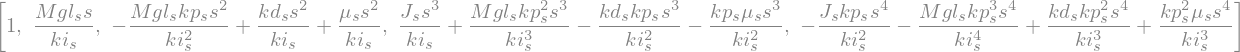

In [98]:
terms=(1/Gyr_s.to_expr()).series(s,0,None)
Gyr_terms=[next(terms) for i in range(5)]
Gyr_terms

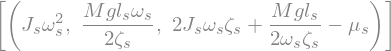

In [99]:
# s^0 の項はどちらも1なので、省略
sols=sympy.solve(
   [
     Msys_terms[1] - Gyr_terms[1],
     Msys_terms[2] - Gyr_terms[2],
     Gyr_terms[3]
   ], (kp_s,ki_s,kd_s))
sols

値を代入して、比べてみましょう。

In [100]:
[[ e.subs({omega_s:omega_n, zeta_s:zeta,J_s:J,mu_s:mu,Mgl_s:Mgl}).simplify() for e in sol] 
for sol in sols]

In [101]:
kp,ki,kd

無駄時間を考慮した場合は、次のようになります。

In [102]:
terms=(1/Gyr_ds.to_expr()).series(s,0,None)
Gyrd_terms=[next(terms) for i in range(5)]

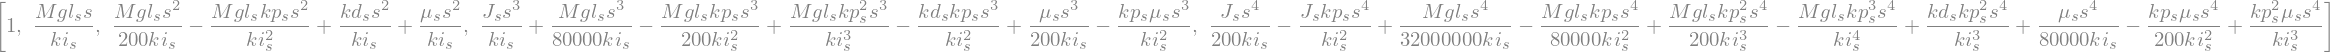

In [103]:
Gyrd_terms

In [104]:
[[ e.subs({omega_s:omega_n, zeta_s:zeta,J_s:J,mu_s:mu,Mgl_s:Mgl}).simplify() for e in sol] 
 for sol in sympy.solve(
   [
     Msys_terms[1] - Gyrd_terms[1],
     Msys_terms[2] - Gyrd_terms[2],
     Gyrd_terms[3]], (kp_s,ki_s,kd_s)
 )
]